In [1]:
import os
import git
from pathlib import Path
from typing import List
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import plotly.express as px
import ipywidgets as widgets
from IPython.display import display
import numpy as np
import plotly.graph_objects as go
from IPython.display import clear_output
import scipy
from scipy import stats
from scipy.spatial import ConvexHull
import pylustrator
from scipy.spatial import Delaunay
from scipy.spatial import distance
from sklearn.decomposition import PCA

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
plots_path = os.path.join(ROOT_DIR, "publication", "paper", "CSVs")


In [2]:
def find_cov_matrix(root_dir: str) -> List[str]:
    root_path = Path(root_dir)
    if not root_path.exists():
        raise FileNotFoundError(f"Directory not found: {root_dir}")

    master_df_paths = []
    for current_dir, _, files in os.walk(root_path):
        if 'covariance_matrix.csv' in files:
            master_df_path = Path(os.path.join(current_dir, 'covariance_matrix.csv'))
            master_df_paths.append(str(master_df_path.absolute()))
    return master_df_paths


all_cov_paths = find_cov_matrix(os.path.join(ROOT_DIR, "results", "case-studies"))
all_cov_dfs = []




for path in all_cov_paths:
    if 'scaleTesting' in path:
        continue
    cov_master_df = pd.DataFrame(columns=['dataset', 'transform', 'subset', 'channel', 'orientation', 'dataset_type'], index=[0])

    parts = Path(path).parts[-7:]
    if parts[0] == 'case-studies':
        parts = parts[1:]
    elif parts[0] == 'results':
        parts = parts[2:]
    if "MRI" in path:
        dataset, slice, transform, orientation, _, _ = parts
        cov_master_df['dataset'] = dataset
        cov_master_df['transform'] = transform
        cov_master_df['subset'] = slice
        cov_master_df['channel'] = np.nan
        cov_master_df['orientation'] = orientation
       
    elif len(parts) > 6:
        dataset, subset, transform, orientation, channel, _, _ = parts
        cov_master_df['dataset'] = dataset
        cov_master_df['transform'] = transform
        cov_master_df['subset'] = subset
        cov_master_df['channel'] = channel
        cov_master_df['orientation'] = orientation
       
    elif "learned" in path:
        dataset, subset, transform, _, _ = parts
        cov_master_df['dataset'] = dataset
        cov_master_df['transform'] = transform
        cov_master_df['subset'] = subset
        cov_master_df = cov_master_df.rename(columns={'filter_group' : 'orientation'})
        cov_master_df['channel'] = np.nan
       

    else:
        dataset, size, transform, channel, _, _ = parts
        
        cov_master_df['dataset'] = dataset
        cov_master_df['transform'] = transform
        cov_master_df['subset'] = size
        cov_master_df['channel'] = channel
        cov_master_df['orientation'] = np.nan
       
    
    if dataset in ['pastis', 'agriVision', 'spaceNet']:
        cov_master_df['dataset_type'] = 'remote sensing'
    elif dataset in ['syntheticMRI2D', 'syntheticMRI3D']:
        cov_master_df['dataset_type'] = 'medical'
    elif dataset in ['coco', 'segmentAnything', 'standardTesting']:
        cov_master_df['dataset_type'] = 'natural'
    # elif dataset in ['standardTesting']:
    #     master_df['dataset_type'] = 'classical'
    cov_matrix = pd.read_csv(path[:-26] + "CSVs" + os.sep + "covariance_matrix.csv").drop(columns=['Unnamed: 0'], axis = 1).to_numpy()
    
   
    pca = PCA()
    
    pca.fit(cov_matrix)
    eigenvectors = pca.components_
    group_num = eigenvectors.shape[0]

    cov_master_df["fro_norm"] = np.linalg.norm(cov_matrix - np.diag(np.diag(cov_matrix)))/group_num**2
    cov_master_df["rel_fro_norm"] = np.linalg.norm(cov_matrix - np.diag(np.diag(cov_matrix))) / np.linalg.trace(cov_matrix)
    cos_dist = distance.cdist(eigenvectors, np.eye(group_num), metric='cosine')
    min_cos_dist = [np.min(row) for row in cos_dist.T]
    arg_min_cos_dist = [np.argmin(row) for row in cos_dist.T]
    cov_master_df["cov_matrix"] = [cov_matrix]
    cov_master_df["pca_comp"] = [arg_min_cos_dist]
    cov_master_df["cosine_dist"] = [min_cos_dist]
    cov_master_df["num_groups"] = group_num
    all_cov_dfs.append(cov_master_df)
    
cov_main_df = pd.concat(all_cov_dfs)


In [3]:
cov_main_df["max_cosine_dist"] = cov_main_df["cosine_dist"].apply(lambda x: np.max(x))

cov_main_df["median_cosine_dist"] = cov_main_df["cosine_dist"].apply(lambda x: np.median(x))
cov_main_df["75_percentile_cosine_dist"] = cov_main_df["cosine_dist"].apply(lambda x: np.percentile(x, 75))
cov_main_df["90_percentile_cosine_dist"] = cov_main_df["cosine_dist"].apply(lambda x: np.percentile(x, 90))


In [4]:
name_mapping = {'syntheticMRI3Dfull': 'syntheticMRI3D',
                'syntheticMRI2Daxial': 'syntheticMRI2D (axial)',
                'syntheticMRI2Dsagittal': 'syntheticMRI2D (sagittal)',
                'syntheticMRI2Dcoronal': 'syntheticMRI2D (coronal)',
                'spaceNetfull': 'spaceNet',
                'cocoindoor': 'coco (indoor)',
                'cocooutdoor': 'coco (outdoor)',
                'pastisfull': 'pastis',
                'segmentAnythingfull': 'segmentAnything',
                'agriVisionfull': 'agriVision',
                'standardTestingfull': 'standardTesting'}

cov_main_df['dataset'] = (cov_main_df['dataset'] + cov_main_df['subset']).replace(name_mapping)

In [5]:
cov_main_df["pca_val_max_cosine_dist"] = cov_main_df.apply(
    lambda row: row["pca_comp"][np.argmax(row["cosine_dist"])], axis=1
)

In [6]:
granularity1 = ['transform', 'dataset_type', 'dataset']
summary_df1 = cov_main_df[np.append(granularity1, ["num_groups", "rel_fro_norm", "median_cosine_dist",  "90_percentile_cosine_dist", "max_cosine_dist"])].groupby(granularity1
    ).agg({
        #"fro_norm": "mean",
        "num_groups": "mean",
        "rel_fro_norm": "mean",
        
        #"cosine_dist": lambda x: np.concatenate(x.values)
        "median_cosine_dist":"mean",
        #"75_percentile_cosine_dist":"mean",
        "90_percentile_cosine_dist":"mean",
        "max_cosine_dist":"mean"
    })
summary_df1


num_groups  rel_fro_norm  \
transform dataset_type   dataset                                               
fourier   remote sensing agriVision                       32.0      0.000030   
                         pastis                           32.0      0.000032   
                         spaceNet                         23.0      0.000025   
learned   natural        coco (indoor)                    62.0      0.000031   
                         coco (outdoor)                   64.0      0.000031   
                         segmentAnything                  64.0      0.000031   
          remote sensing agriVision                       60.0      0.000032   
                         pastis                           32.0      0.000032   
                         spaceNet                         56.0      0.000030   
wavelet   medical        syntheticMRI2D (axial)            7.0      0.000010   
                         syntheticMRI2D (coronal)          7.0      0.000024   
                         syntheticMRI2D (sagittal)         7.0      0.000012   
                         syntheticMRI3D                    6.0      0.000034   
          natural        coco (indoor)                     8.0      0.000023   
                         coco (outdoor)                    8.0      0.000006   
                         segmentAnything                   9.0      0.000010   
          remote sensing agriVision                        9.0      0.000017   
                         pastis                            7.0      0.000017   
                         spaceNet                          8.0      0.000015   

                                                    median_cosine_dist  \
transform dataset_type   dataset                                         
fourier   remote sensing agriVision                           0.059083   
                         pastis                               0.027254   
                         spaceNet                             0.013810   
learned   natural        coco (indoor)                        0.182995   
                         coco (outdoor)                       0.176613   
                         segmentAnything                      0.192099   
          remote sensing agriVision                           0.194457   
                         pastis                               0.210158   
                         spaceNet                             0.226151   
wavelet   medical        syntheticMRI2D (axial)               0.005879   
                         syntheticMRI2D (coronal)             0.006403   
                         syntheticMRI2D (sagittal)            0.009791   
                         syntheticMRI3D                       0.004111   
          natural        coco (indoor)                        0.002089   
                         coco (outdoor)                       0.003229   
                         segmentAnything                      0.003141   
          remote sensing agriVision                           0.004831   
                         pastis                               0.003826   
                         spaceNet                             0.005042   

                                                    90_percentile_cosine_dist  \
transform dataset_type   dataset                                                
fourier   remote sensing agriVision                                  0.168300   
                         pastis                                      0.069756   
                         spaceNet                                    0.139616   
learned   natural        coco (indoor)                               0.327031   
                         coco (outdoor)                              0.302042   
                         segmentAnything                             0.356366   
          remote sensing agriVision                                  0.501123   
                         pastis                                      0.389679   
      

In [7]:
granularity2 = ['transform', 'dataset_type']
summary_df2 = cov_main_df[np.append(granularity2, [ "num_groups", "rel_fro_norm",  "median_cosine_dist", "90_percentile_cosine_dist","max_cosine_dist"])].groupby(granularity2
    ).agg({
        #"fro_norm": "mean",
        "num_groups": "mean",
        "rel_fro_norm": "mean",
        #"cosine_dist": lambda x: np.concatenate(x.values)
        "median_cosine_dist":"mean",
        #"75_percentile_cosine_dist":"mean",
        "90_percentile_cosine_dist":"mean",
        "max_cosine_dist":"mean"
    })

summary_df2
summary_df2 = summary_df2.assign(dataset='z_aggregate').reset_index().set_index(granularity1)
summary_df_final = pd.concat([summary_df1, summary_df2]).reset_index()
summary_df_final
summary_df_final

,transform,dataset_type,dataset,num_groups,rel_fro_norm,median_cosine_dist,90_percentile_cosine_dist,max_cosine_dist
0,fourier,remote sensing,agriVision,32.000000,0.000030,0.059083,0.168300,0.245595
1,fourier,remote sensing,pastis,32.000000,0.000032,0.027254,0.069756,0.146633
2,fourier,remote sensing,spaceNet,23.000000,0.000025,0.013810,0.139616,0.309163
3,learned,natural,coco (indoor),62.000000,0.000031,0.182995,0.327031,0.898455
4,learned,natural,coco (outdoor),64.000000,0.000031,0.176613,0.302042,0.880569
5,learned,natural,segmentAnything,64.000000,0.000031,0.192099,0.356366,0.915657
6,learned,remote sensing,agriVision,60.000000,0.000032,0.194457,0.501123,0.902932
7,learned,remote sensing,pastis,32.000000,0.000032,0.210158,0.389679,0.858551
8,learned,remote sensing,spaceNet,56.000000,0.000030,0.226151,0.470251,0.920607
9,wavelet,medical,syntheticMRI2D (axial),7.000000,0.000010,0.005879,0.013088,0.014245


In [8]:
summary_df_final['transform'] = pd.Categorical(summary_df_final['transform'], categories=['fourier', 'wavelet', 'learned'], ordered=True)
summary_df_final = summary_df_final.sort_values(['transform', 'dataset_type', 'dataset'])
summary_df_final =summary_df_final.rename(columns={
    'num_groups': 'Number of Groups',
    'rel_fro_norm': 'Relative Frobenius Norm',
    
    'median_cosine_dist': 'Median Cosine Distance',
    #'75_percentile_cosine_dist': '75th Percentile Cosine Distance',
    '90_percentile_cosine_dist': '90th Percentile Cosine Distance',
    'max_cosine_dist': 'Max Cosine Distance'
})

cols_to_round = [
    'Number of Groups',
    'Median Cosine Distance',
    '90th Percentile Cosine Distance',
    'Max Cosine Distance'
]
summary_df_final[cols_to_round] = summary_df_final[cols_to_round].round(4)

summary_df_final.to_csv(os.path.join(plots_path, 'results_table.csv'))
summary_df_final

,transform,dataset_type,dataset,Number of Groups,Relative Frobenius Norm,Median Cosine Distance,90th Percentile Cosine Distance,Max Cosine Distance
0,fourier,remote sensing,agriVision,32.0000,0.000030,0.0591,0.1683,0.2456
1,fourier,remote sensing,pastis,32.0000,0.000032,0.0273,0.0698,0.1466
2,fourier,remote sensing,spaceNet,23.0000,0.000025,0.0138,0.1396,0.3092
19,fourier,remote sensing,z_aggregate,29.0000,0.000029,0.0334,0.1259,0.2338
9,wavelet,medical,syntheticMRI2D (axial),7.0000,0.000010,0.0059,0.0131,0.0142
10,wavelet,medical,syntheticMRI2D (coronal),7.0000,0.000024,0.0064,0.0142,0.0169
11,wavelet,medical,syntheticMRI2D (sagittal),7.0000,0.000012,0.0098,0.0265,0.0284
12,wavelet,medical,syntheticMRI3D,6.0000,0.000034,0.0041,0.0418,0.0427
22,wavelet,medical,z_aggregate,6.5625,0.000024,0.0059,0.0284,0.0299
13,wavelet,natural,coco (indoor),8.0000,0.000023,0.0021,0.0194,0.0220


In [9]:
cov_main_df.sort_values(by=["max_cosine_dist"], ascending=False)

,dataset,transform,subset,channel,orientation,dataset_type,fro_norm,rel_fro_norm,cov_matrix,pca_comp,cosine_dist,num_groups,max_cosine_dist,median_cosine_dist,75_percentile_cosine_dist,90_percentile_cosine_dist,pca_val_max_cosine_dist
0,spaceNet,learned,full,NaN,NaN,remote sensing,0.000020,0.000030,"[[53.27153355627392, 0.0012604622278196, -5.42...","[13, 2, 40, 0, 10, 22, 38, 55, 49, 29, 26, 18,...","[0.4810934456432684, 0.320589259365457, 0.2161...",56,0.920607,0.226151,0.291309,0.470251,55
0,segmentAnything,learned,full,NaN,NaN,natural,0.000003,0.000031,"[[6.042984572324744, 5.205994901288547e-05, -0...","[16, 13, 6, 24, 4, 18, 45, 33, 63, 54, 34, 52,...","[0.12716011406477745, 0.29445070401857576, 0.2...",64,0.915657,0.192099,0.269018,0.356366,63
0,agriVision,learned,full,NaN,NaN,remote sensing,0.000042,0.000032,"[[103.03354544341072, -0.0028678857880977, -0....","[11, 5, 33, 4, 30, 35, 22, 59, 53, 36, 37, 39,...","[0.04433501586384825, 0.016805973002016694, 0....",60,0.902932,0.194457,0.271501,0.501123,39
0,coco (indoor),learned,indoor,NaN,NaN,natural,0.000002,0.000031,"[[4.659782107358874, -3.647869547237924e-05, 6...","[18, 9, 29, 3, 16, 42, 23, 61, 46, 39, 51, 53,...","[0.10407926303231052, 0.21690933641831078, 0.1...",62,0.898455,0.182995,0.275744,0.327031,43
0,coco (outdoor),learned,outdoor,NaN,NaN,natural,0.000002,0.000031,"[[5.720460563932559, 3.4994358963800976e-05, -...","[16, 10, 8, 24, 4, 18, 50, 36, 62, 48, 37, 56,...","[0.08702928002332677, 0.1760124007544479, 0.10...",64,0.880569,0.176613,0.232287,0.302042,48
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,syntheticMRI3D,wavelet,full,NaN,ada,medical,2.869023,0.000034,"[[1917600.8642076051, -72.13523217898357, 6.01...","[0, 1, 2, 3, 4, 5]","[0.005496269392774811, 0.008791564895835102, 0...",6,0.008792,0.005283,0.005821,0.007361,1
0,syntheticMRI3D,wavelet,full,NaN,dad,medical,1.738852,0.000034,"[[1177878.966759853, -43.908919420273975, 3.30...","[0, 1, 2, 3, 4, 5]","[0.0071158361123742075, 0.007835469565315778, ...",6,0.007835,0.003364,0.006180,0.007476,1
0,pastis,wavelet,full,blue,diagonal,remote sensing,0.000757,0.000019,"[[1389.1300170718644, 0.0018619141245075, 0.02...","[0, 1, 2, 3, 4, 5, 6]","[0.0017918996674231025, 0.0031365453737177695,...",7,0.007165,0.003137,0.004404,0.005601,5
0,syntheticMRI2D (coronal),wavelet,coronal,NaN,vertical,medical,0.719603,0.000024,"[[946850.547172709, 22.07649902169089, -0.2779...","[0, 1, 2, 3, 4, 5, 6]","[0.0035884265628040035, 0.005606282168073129, ...",7,0.006023,0.005514,0.005805,0.006011,3


In [10]:
#pd.set_option('display.max_rows', None)
cov_main_df.sort_values(by=["pca_val_max_cosine_dist"], ascending=True)


,dataset,transform,subset,channel,orientation,dataset_type,fro_norm,rel_fro_norm,cov_matrix,pca_comp,cosine_dist,num_groups,max_cosine_dist,median_cosine_dist,75_percentile_cosine_dist,90_percentile_cosine_dist,pca_val_max_cosine_dist
0,syntheticMRI3D,wavelet,full,NaN,ada,medical,2.869023,0.000034,"[[1917600.8642076051, -72.13523217898357, 6.01...","[0, 1, 2, 3, 4, 5]","[0.005496269392774811, 0.008791564895835102, 0...",6,0.008792,0.005283,0.005821,0.007361,1
0,syntheticMRI2D (coronal),wavelet,coronal,NaN,diagonal,medical,0.116475,0.000022,"[[79740.57036741712, 2.413187175238488, 0.0883...","[1, 0, 2, 3, 4, 5, 6]","[0.020406154735044257, 0.013472938737863815, 0...",7,0.020406,0.006025,0.013819,0.016661,1
0,syntheticMRI3D,wavelet,full,NaN,ddd,medical,0.733535,0.000036,"[[455496.08096382767, -18.56441006515787, 1.31...","[0, 1, 2, 3, 4, 5]","[0.010335821553539626, 0.01091115307259749, 0....",6,0.010911,0.002793,0.008487,0.010623,1
0,syntheticMRI3D,wavelet,full,NaN,daa,medical,2.317963,0.000034,"[[1150226.2635556564, -57.67197566032464, 3.90...","[0, 1, 2, 3, 4, 5]","[0.06390562413702716, 0.0690665826265977, 0.01...",6,0.069067,0.007865,0.050615,0.066486,1
0,syntheticMRI3D,wavelet,full,NaN,add,medical,1.825190,0.000039,"[[849832.2641610664, -46.07839528385831, 3.145...","[0, 1, 2, 3, 4, 5]","[0.12499847954208343, 0.12545360816175455, 0.0...",6,0.125454,0.002827,0.094457,0.125226,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,agriVision,learned,full,NaN,NaN,remote sensing,0.000042,0.000032,"[[103.03354544341072, -0.0028678857880977, -0....","[11, 5, 33, 4, 30, 35, 22, 59, 53, 36, 37, 39,...","[0.04433501586384825, 0.016805973002016694, 0....",60,0.902932,0.194457,0.271501,0.501123,39
0,coco (indoor),learned,indoor,NaN,NaN,natural,0.000002,0.000031,"[[4.659782107358874, -3.647869547237924e-05, 6...","[18, 9, 29, 3, 16, 42, 23, 61, 46, 39, 51, 53,...","[0.10407926303231052, 0.21690933641831078, 0.1...",62,0.898455,0.182995,0.275744,0.327031,43
0,coco (outdoor),learned,outdoor,NaN,NaN,natural,0.000002,0.000031,"[[5.720460563932559, 3.4994358963800976e-05, -...","[16, 10, 8, 24, 4, 18, 50, 36, 62, 48, 37, 56,...","[0.08702928002332677, 0.1760124007544479, 0.10...",64,0.880569,0.176613,0.232287,0.302042,48
0,spaceNet,learned,full,NaN,NaN,remote sensing,0.000020,0.000030,"[[53.27153355627392, 0.0012604622278196, -5.42...","[13, 2, 40, 0, 10, 22, 38, 55, 49, 29, 26, 18,...","[0.4810934456432684, 0.320589259365457, 0.2161...",56,0.920607,0.226151,0.291309,0.470251,55


In [11]:
#pd.reset_option('display.max_rows')

In [12]:
cov_main_df.sort_values(by = ["fro_norm"], ascending=True)

,dataset,transform,subset,channel,orientation,dataset_type,fro_norm,rel_fro_norm,cov_matrix,pca_comp,cosine_dist,num_groups,max_cosine_dist,median_cosine_dist,75_percentile_cosine_dist,90_percentile_cosine_dist,pca_val_max_cosine_dist
0,pastis,fourier,full,red,NaN,remote sensing,0.000002,0.000032,"[[9.599051230294751, -0.0005512141058465, 0.00...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.0028576882510686907, 0.008366147855379147, ...",32,0.157962,0.028428,0.054644,0.083668,30
0,pastis,fourier,full,gray,NaN,remote sensing,0.000002,0.000032,"[[10.134503578028344, -0.0005987753416604, 0.0...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.0028827294355249222, 0.008808452257685007, ...",32,0.128045,0.027697,0.042695,0.057685,30
0,pastis,fourier,full,green,NaN,remote sensing,0.000002,0.000032,"[[10.047826320177776, -0.0005955596123617, 0.0...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.002965808667178882, 0.009323579008914451, 0...",32,0.150723,0.028639,0.046466,0.072195,30
0,coco (indoor),learned,indoor,NaN,NaN,natural,0.000002,0.000031,"[[4.659782107358874, -3.647869547237924e-05, 6...","[18, 9, 29, 3, 16, 42, 23, 61, 46, 39, 51, 53,...","[0.10407926303231052, 0.21690933641831078, 0.1...",62,0.898455,0.182995,0.275744,0.327031,43
0,pastis,fourier,full,blue,NaN,remote sensing,0.000002,0.000032,"[[14.56437421866709, -0.0008635557542404, 0.00...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.0027978775897574693, 0.008048077922727104, ...",32,0.149804,0.024251,0.039759,0.065478,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,syntheticMRI3D,wavelet,full,NaN,dad,medical,1.738852,0.000034,"[[1177878.966759853, -43.908919420273975, 3.30...","[0, 1, 2, 3, 4, 5]","[0.0071158361123742075, 0.007835469565315778, ...",6,0.007835,0.003364,0.006180,0.007476,1
0,syntheticMRI3D,wavelet,full,NaN,add,medical,1.825190,0.000039,"[[849832.2641610664, -46.07839528385831, 3.145...","[0, 1, 2, 3, 4, 5]","[0.12499847954208343, 0.12545360816175455, 0.0...",6,0.125454,0.002827,0.094457,0.125226,1
0,syntheticMRI3D,wavelet,full,NaN,daa,medical,2.317963,0.000034,"[[1150226.2635556564, -57.67197566032464, 3.90...","[0, 1, 2, 3, 4, 5]","[0.06390562413702716, 0.0690665826265977, 0.01...",6,0.069067,0.007865,0.050615,0.066486,1
0,syntheticMRI3D,wavelet,full,NaN,ada,medical,2.869023,0.000034,"[[1917600.8642076051, -72.13523217898357, 6.01...","[0, 1, 2, 3, 4, 5]","[0.005496269392774811, 0.008791564895835102, 0...",6,0.008792,0.005283,0.005821,0.007361,1


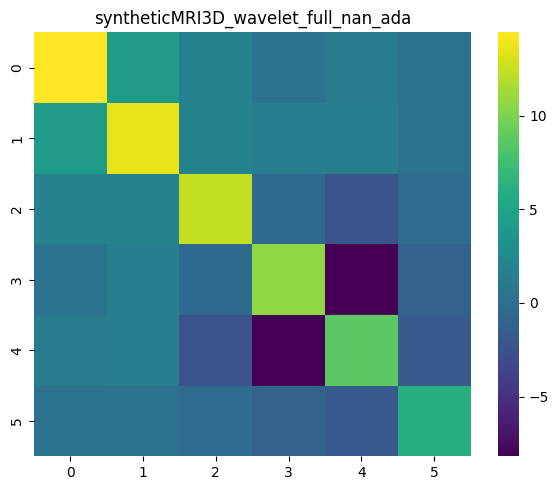

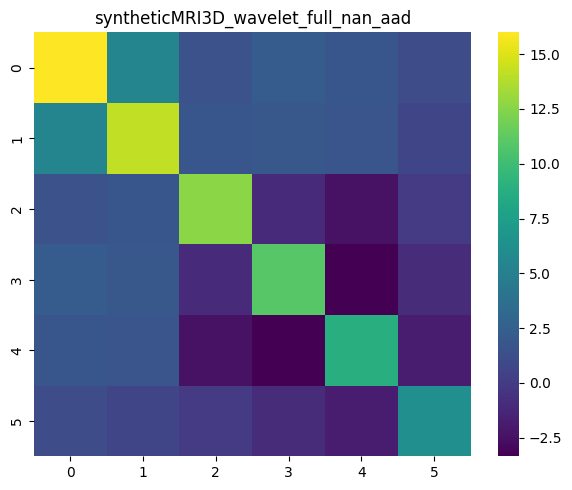

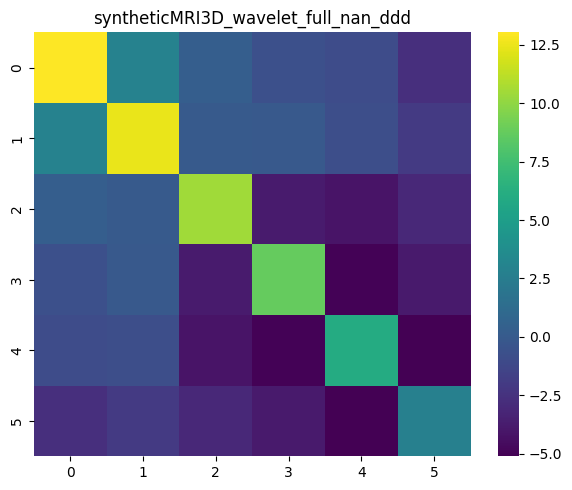

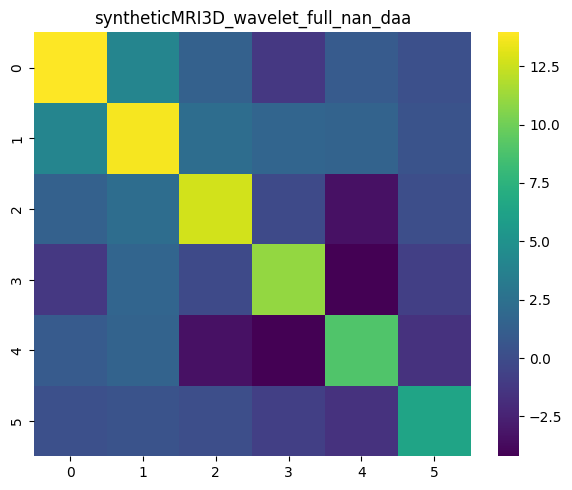

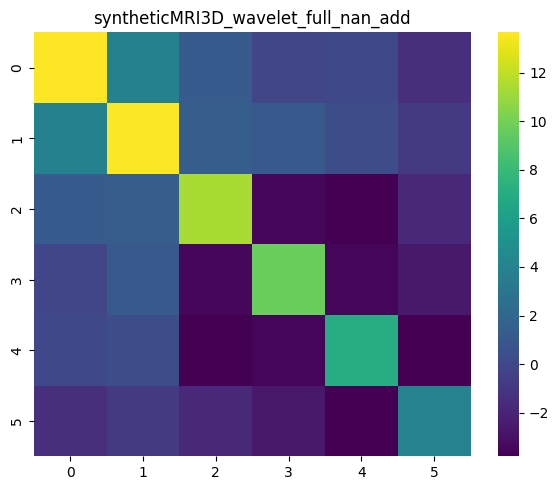

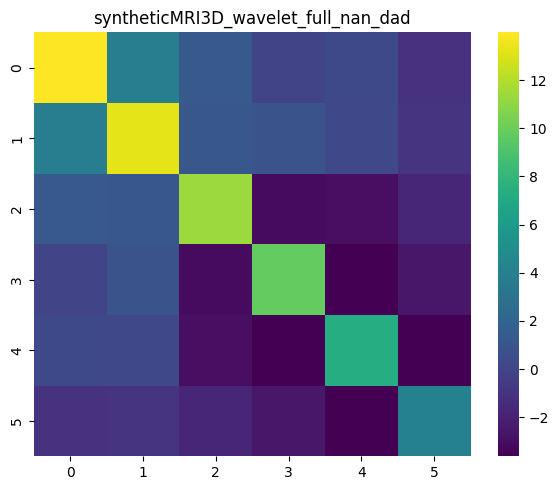

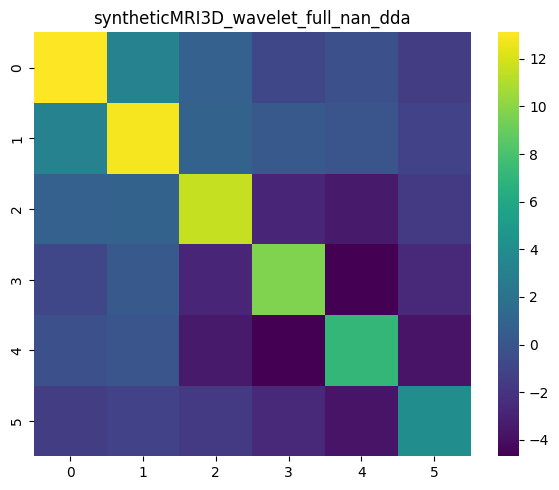

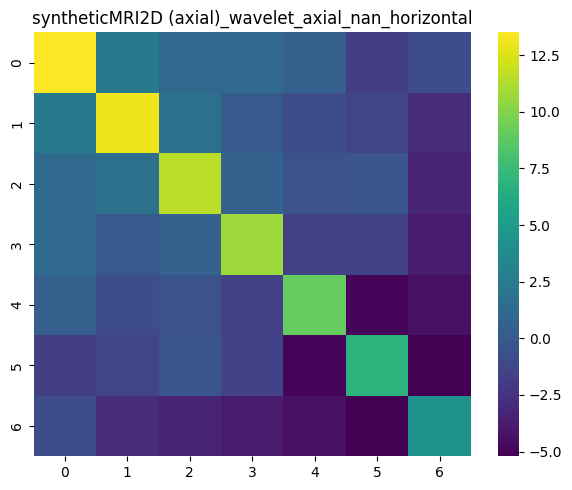

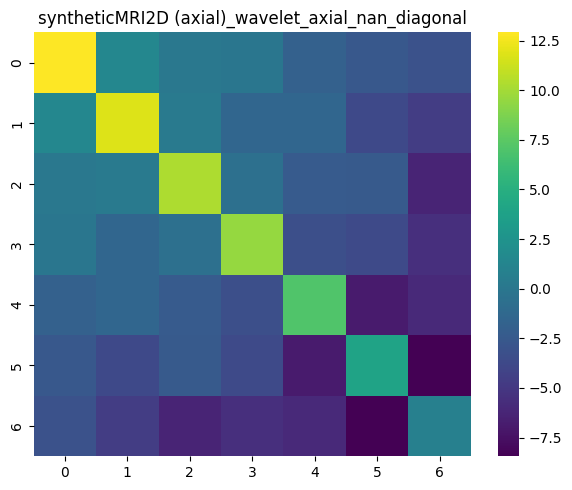

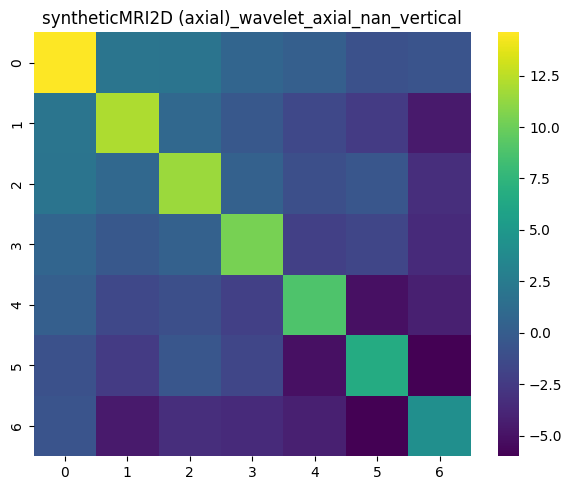

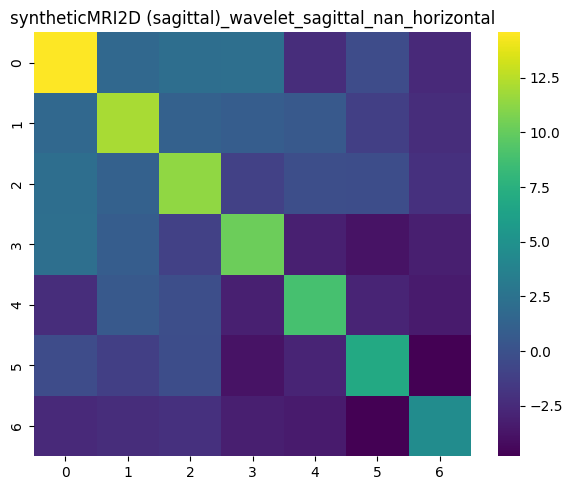

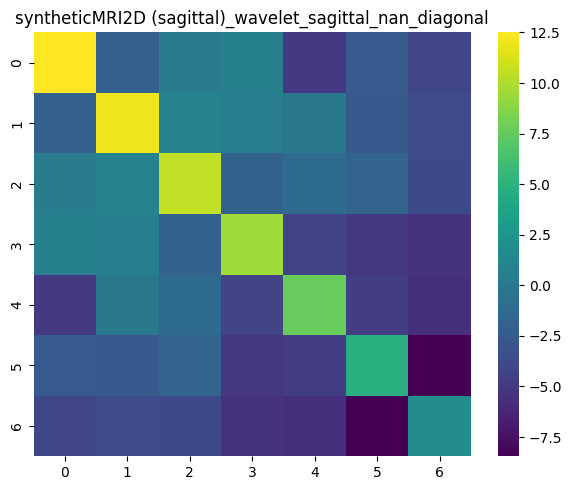

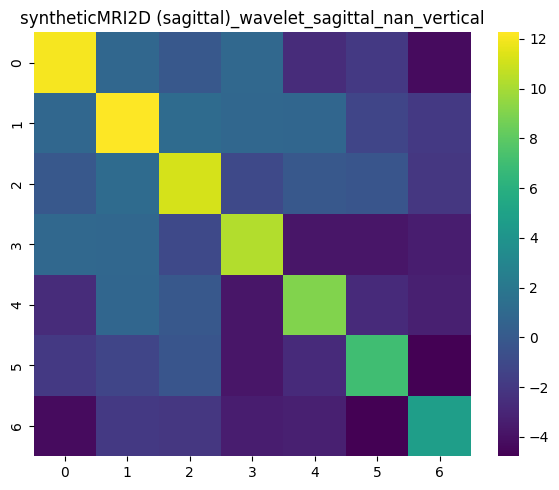

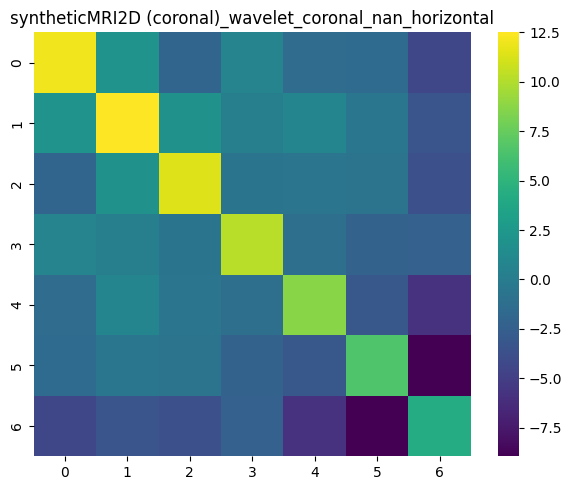

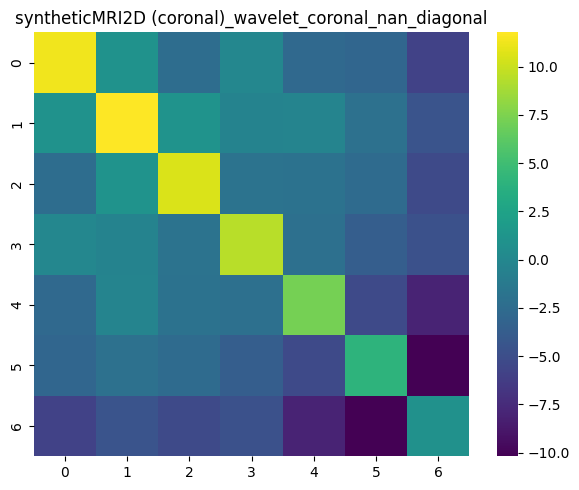

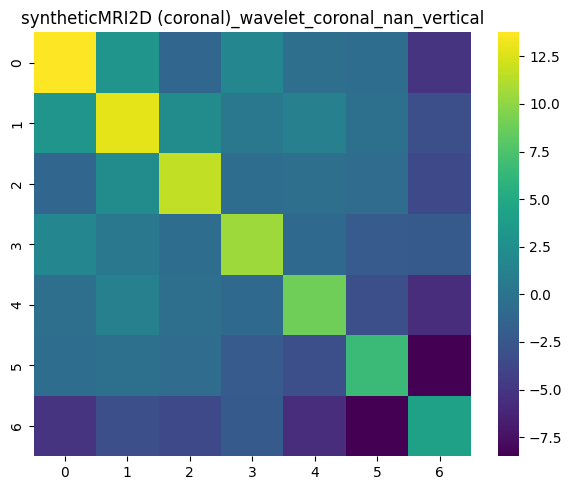

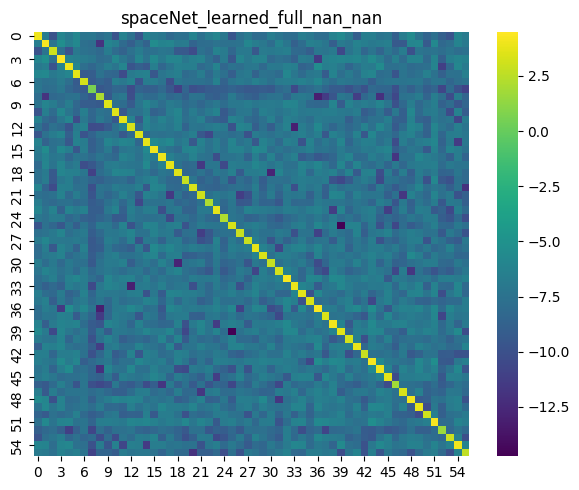

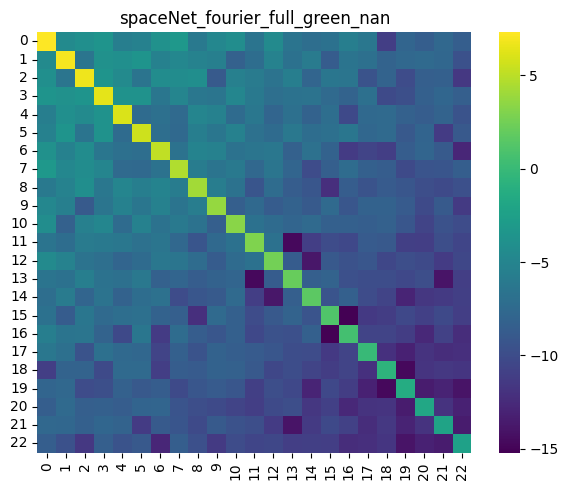

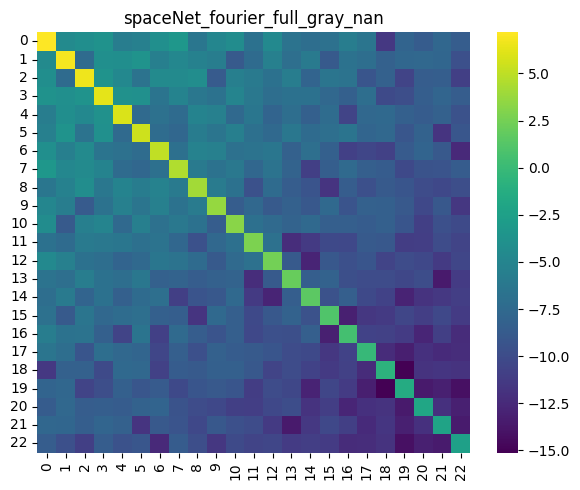

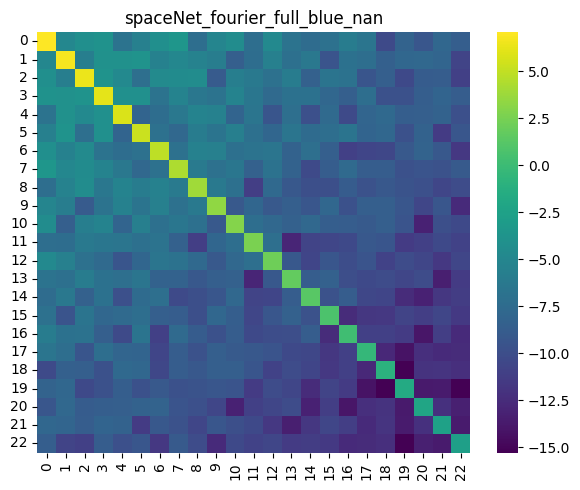

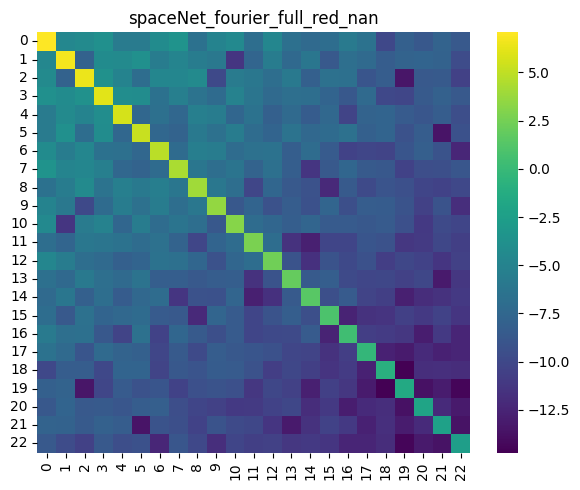

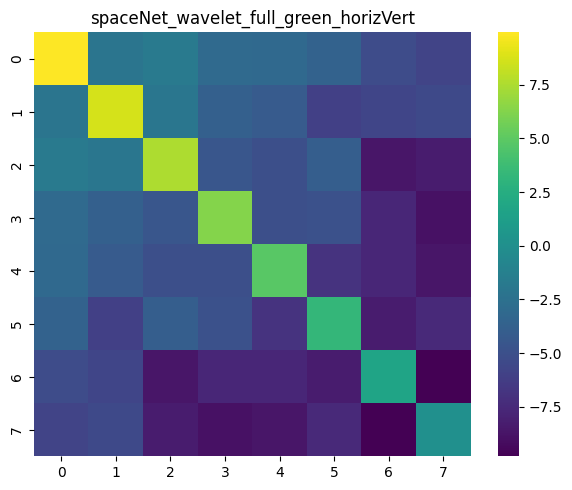

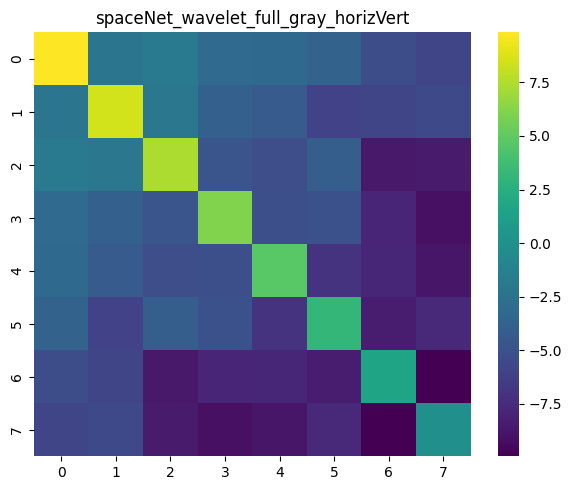

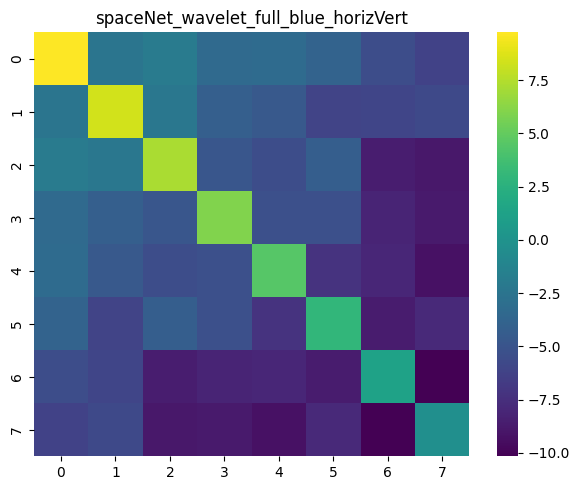

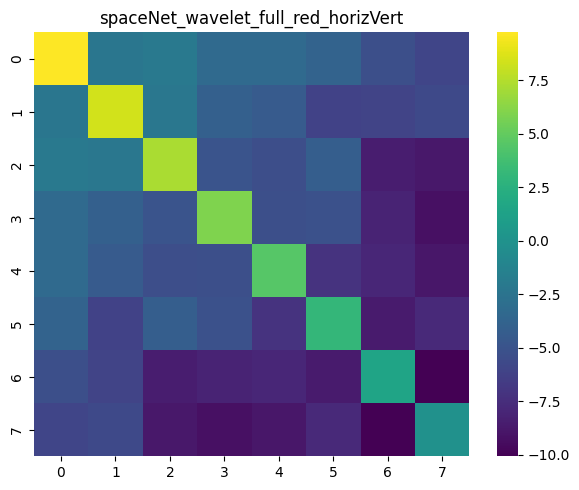

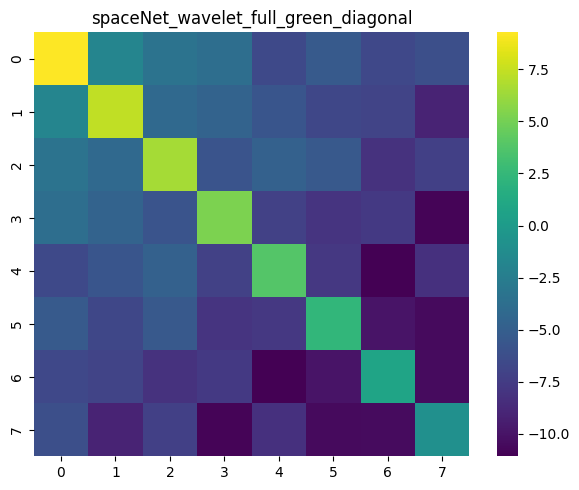

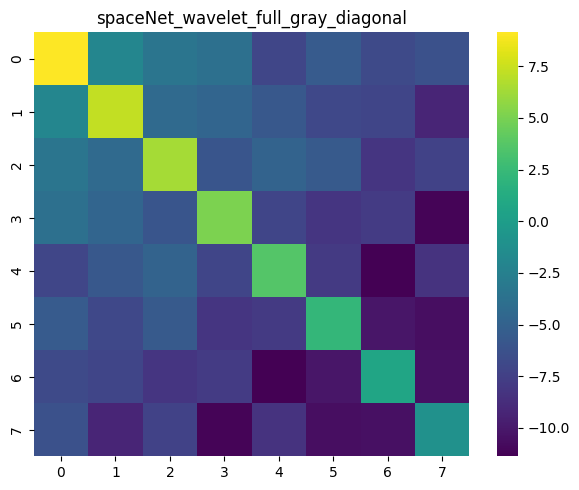

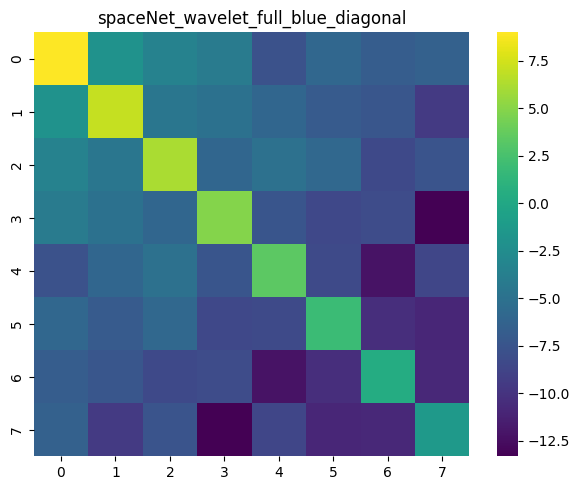

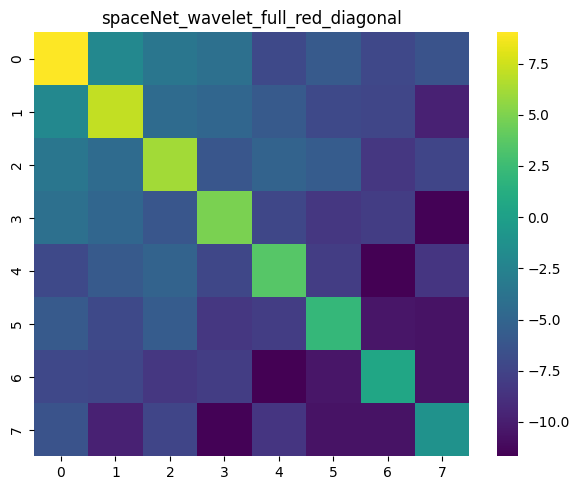

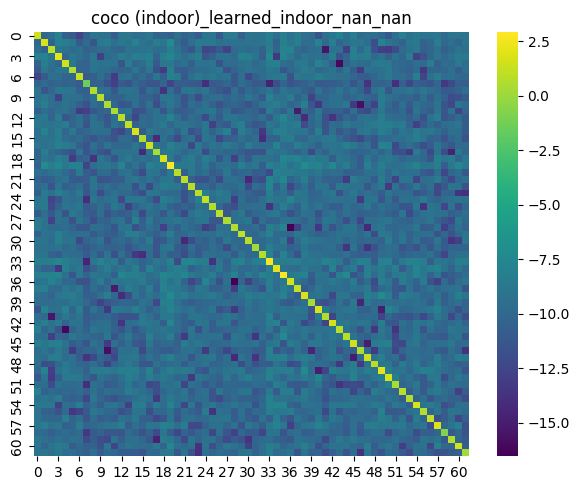

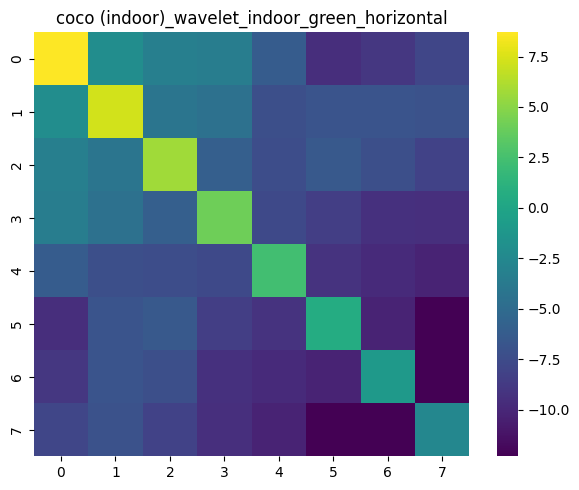

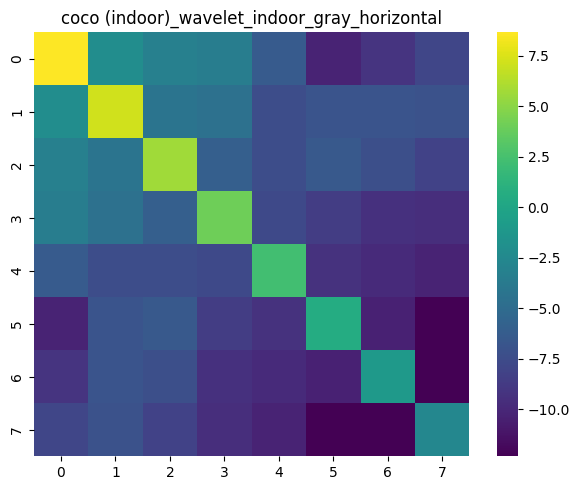

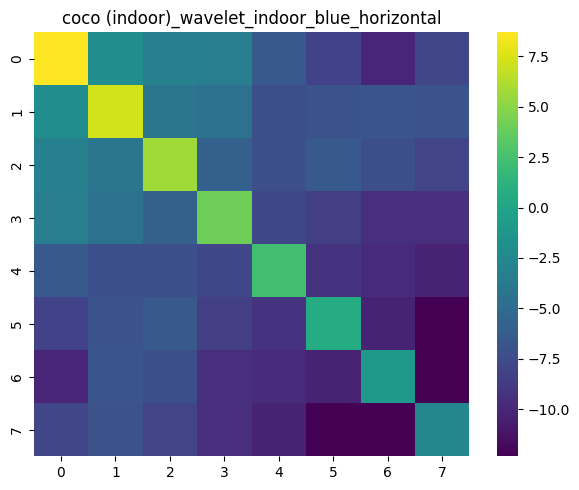

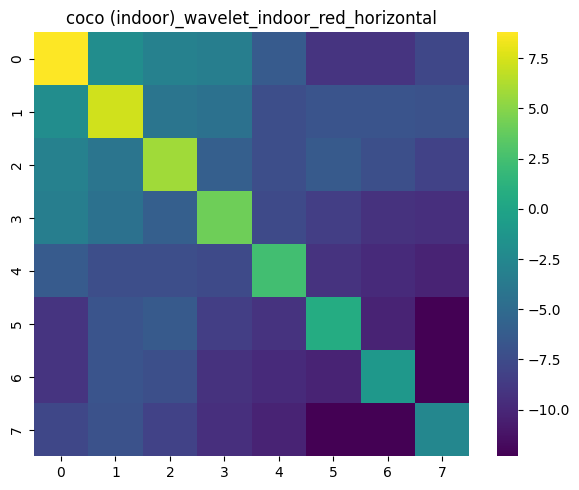

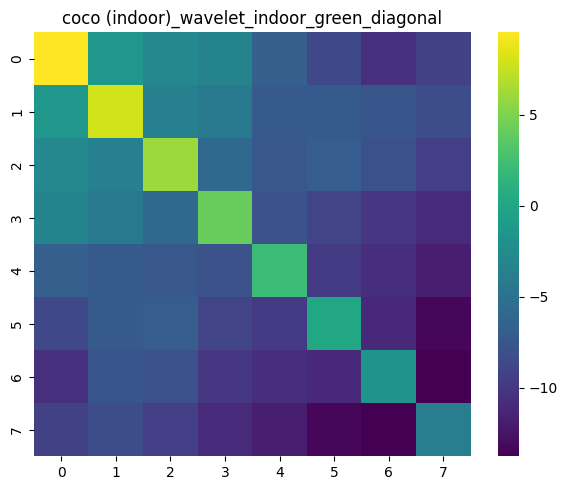

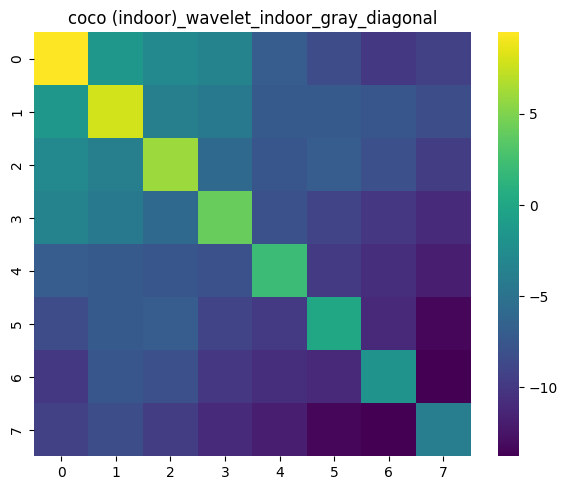

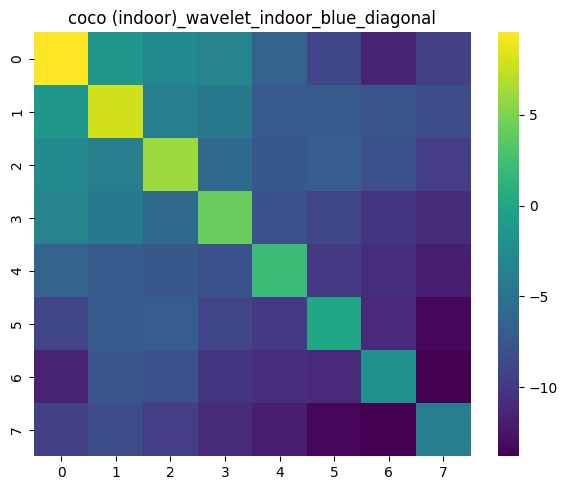

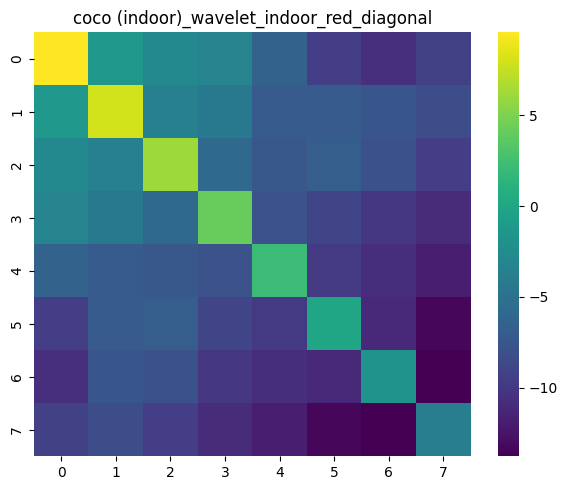

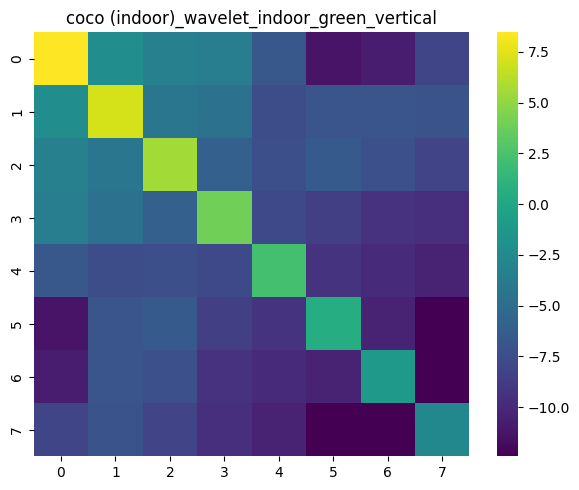

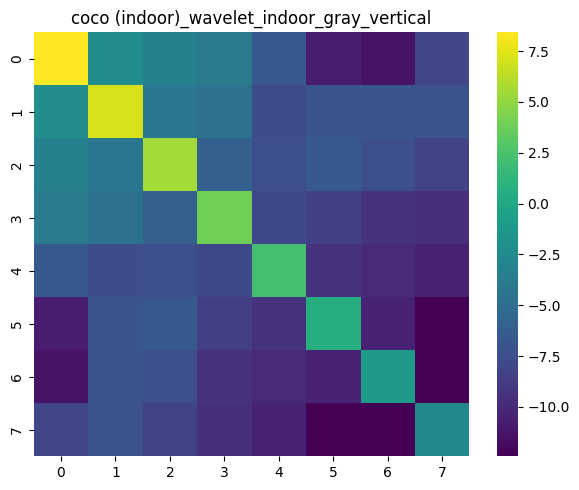

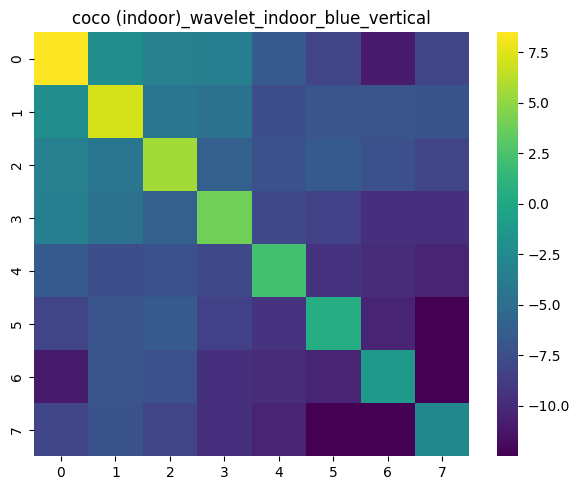

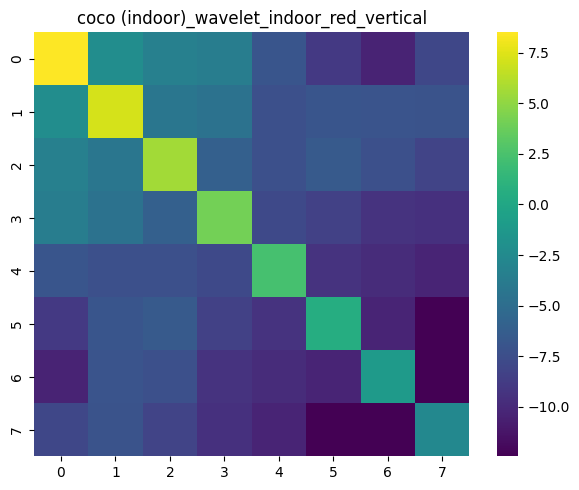

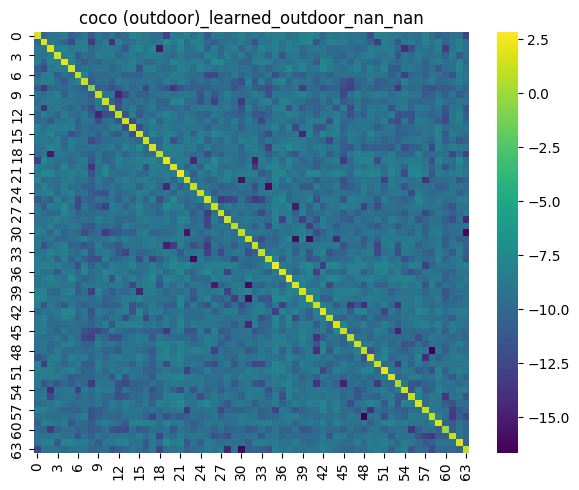

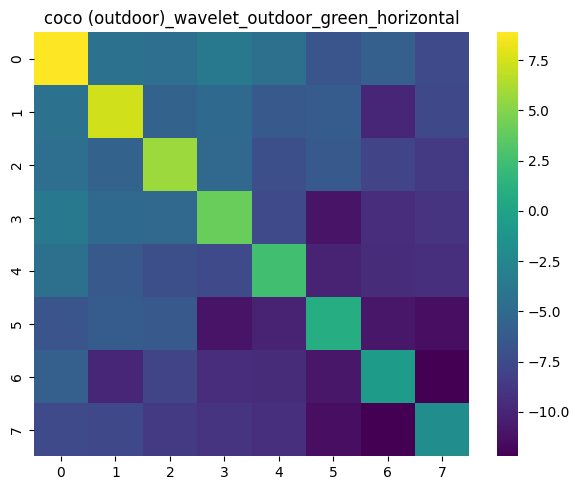

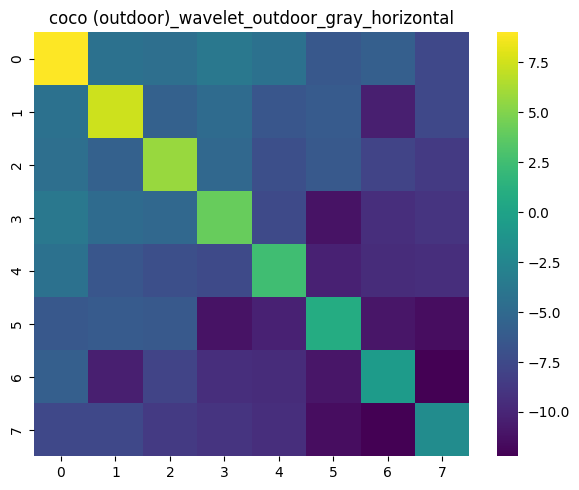

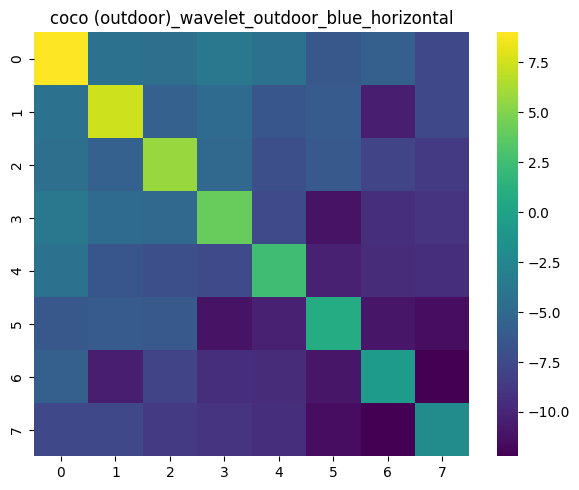

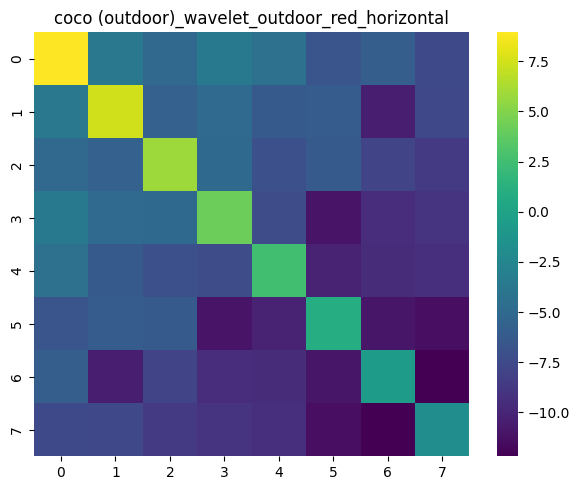

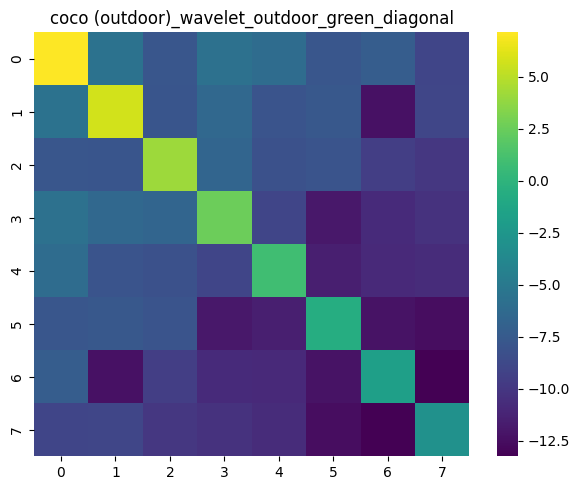

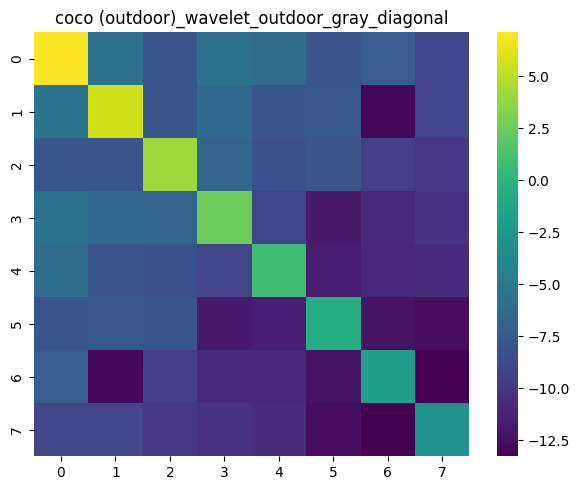

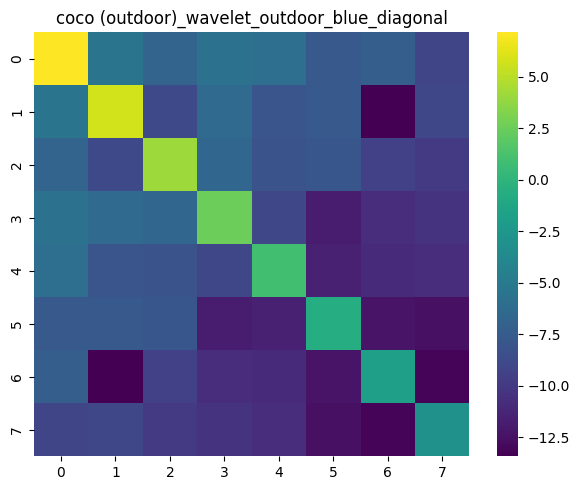

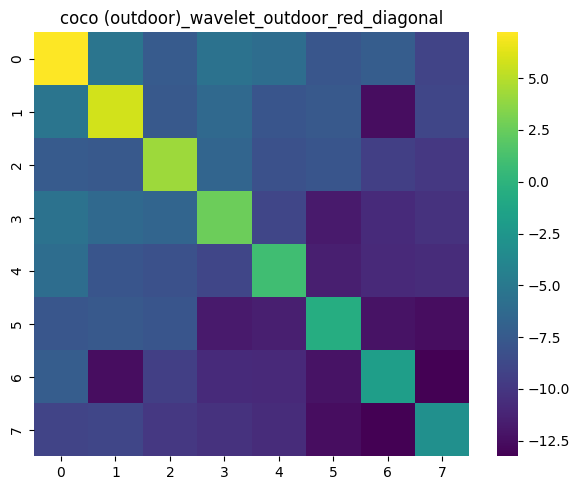

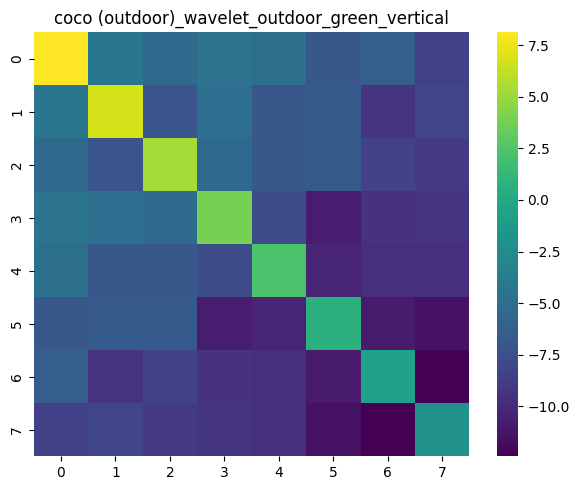

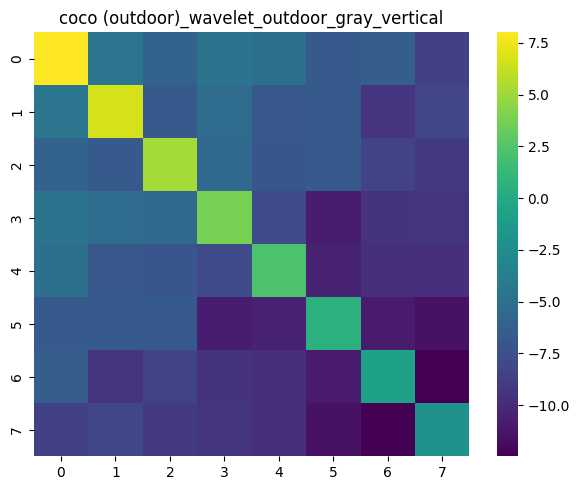

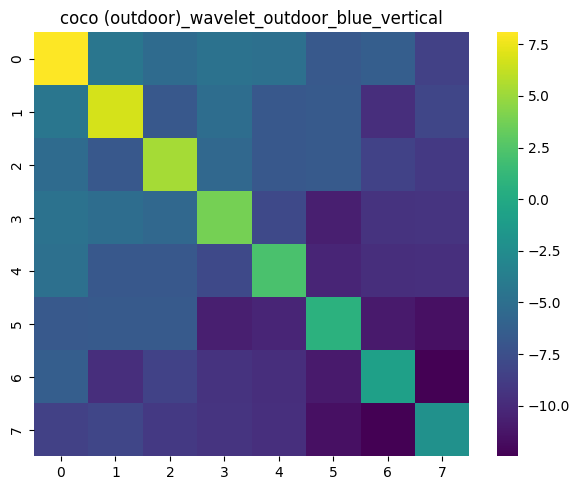

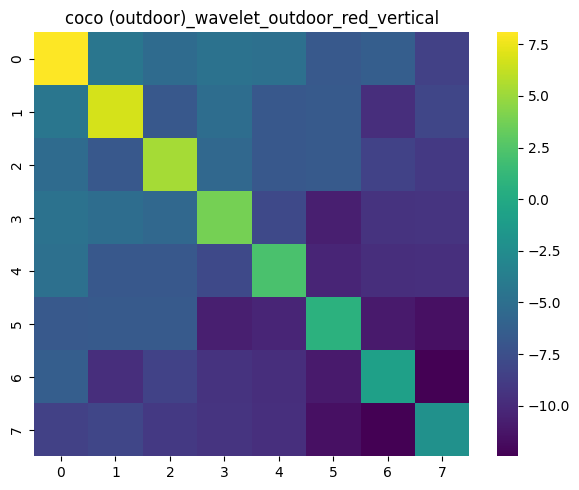

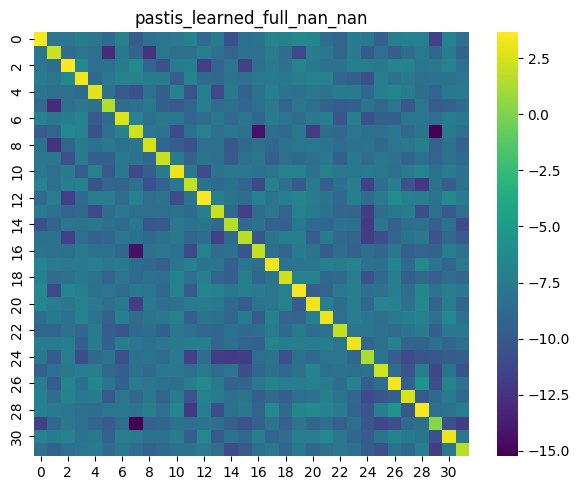

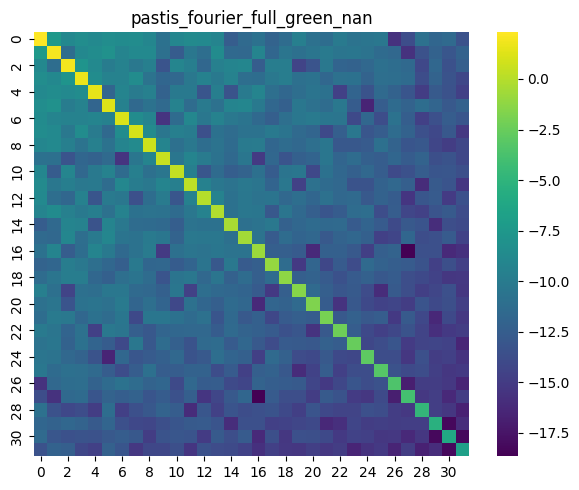

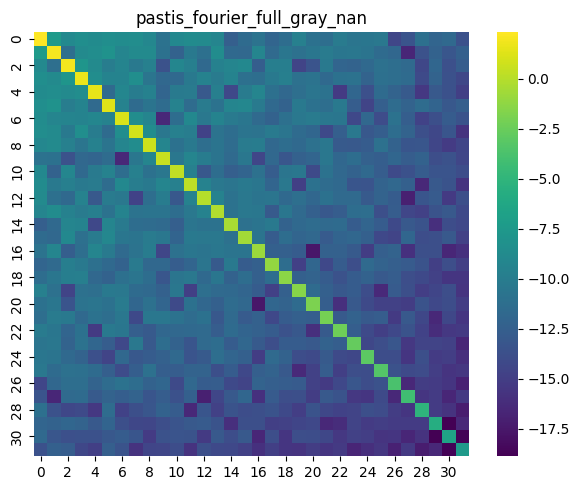

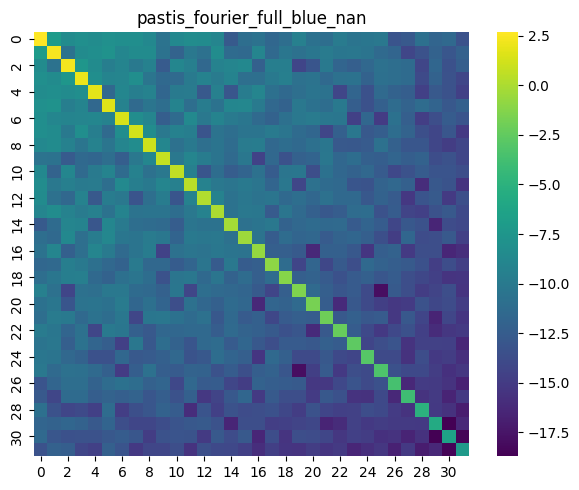

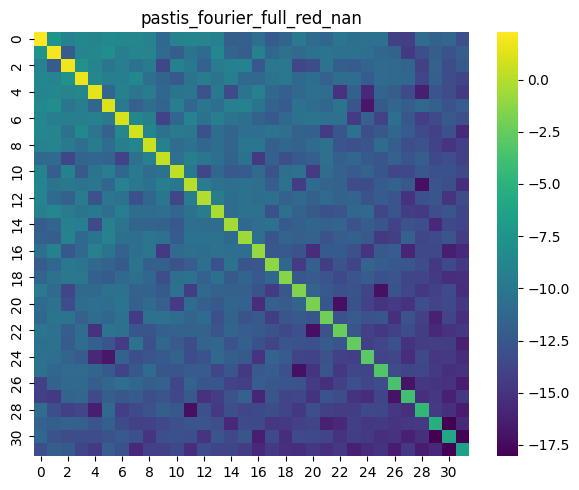

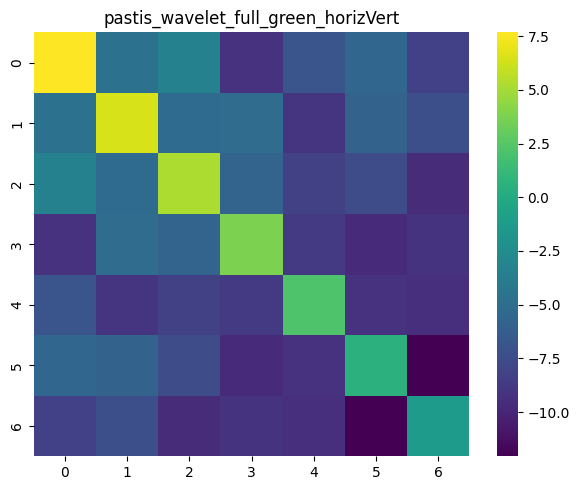

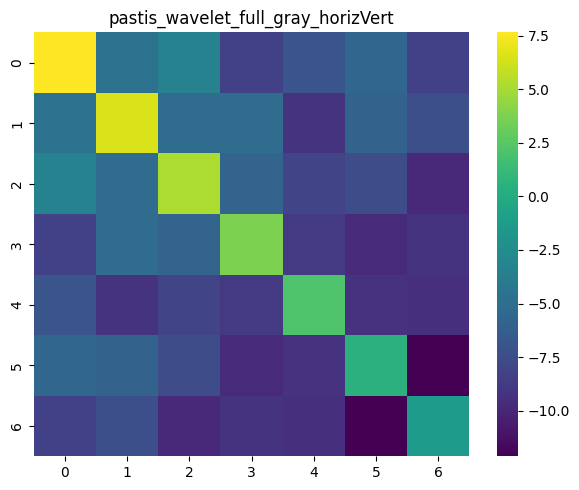

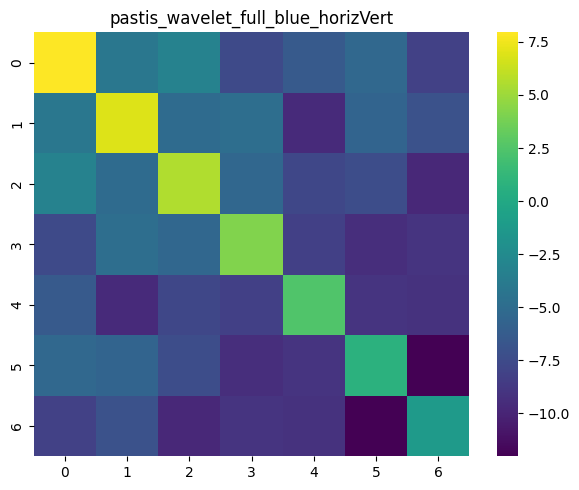

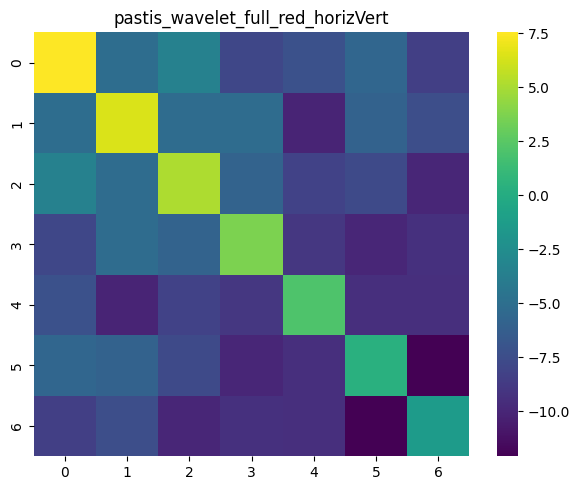

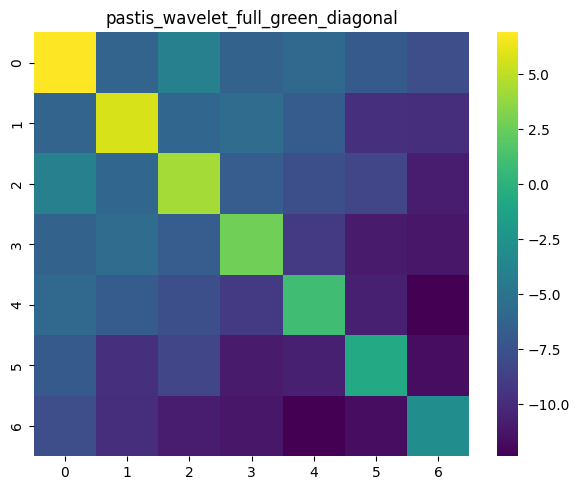

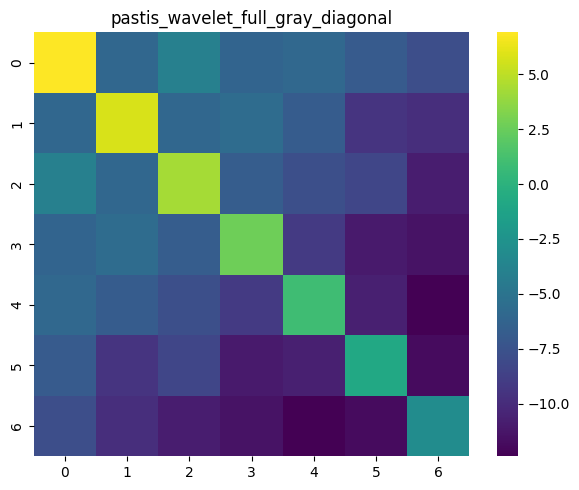

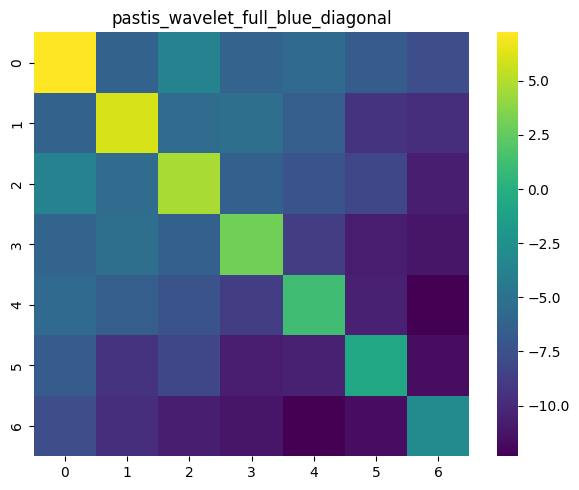

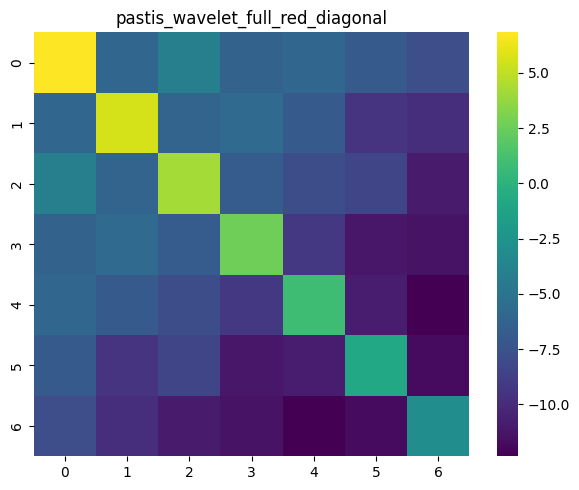

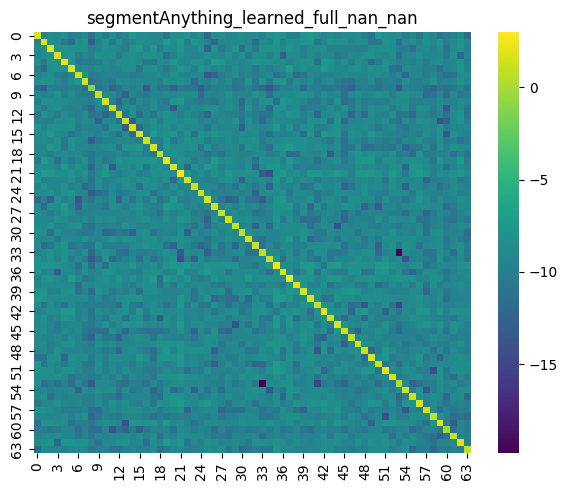

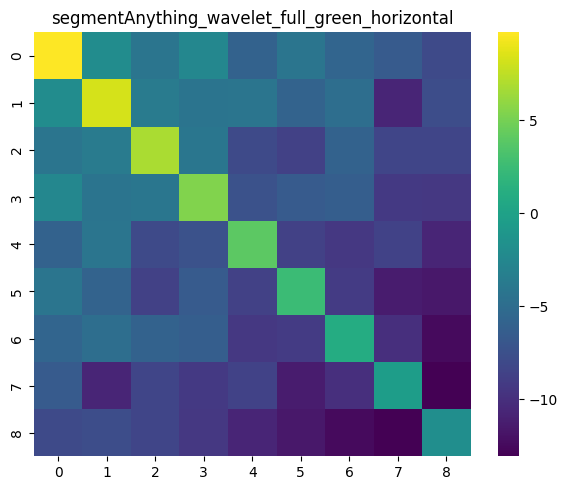

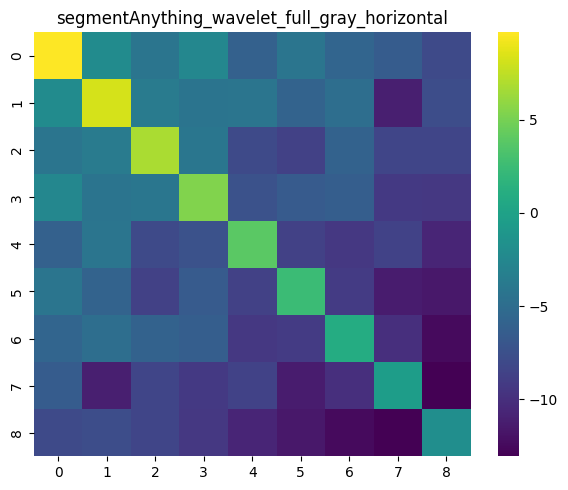

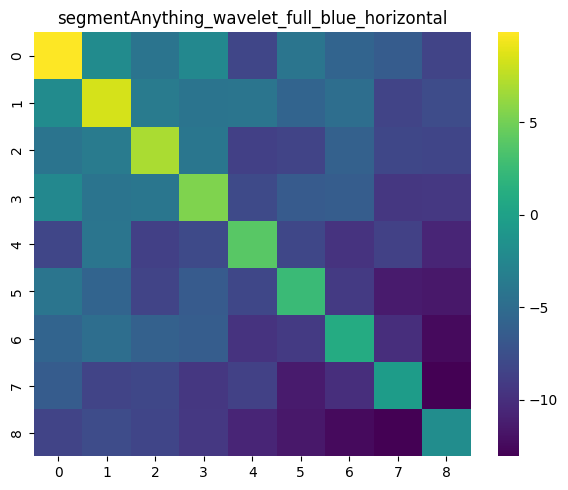

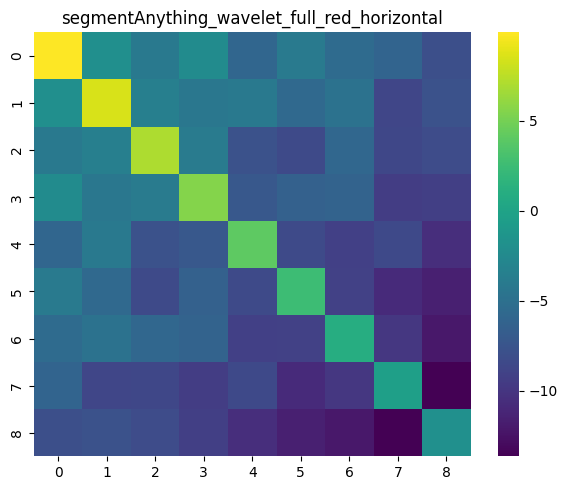

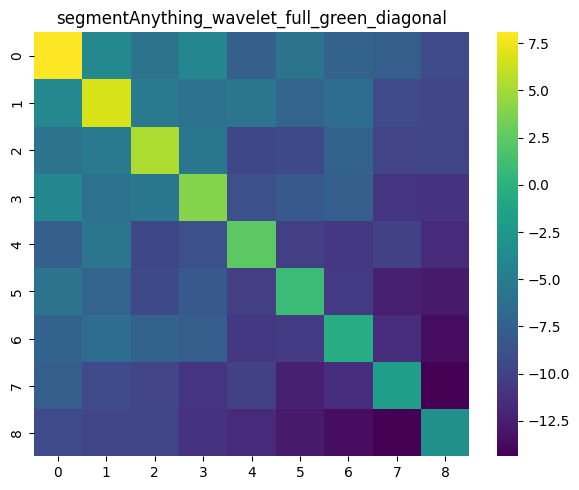

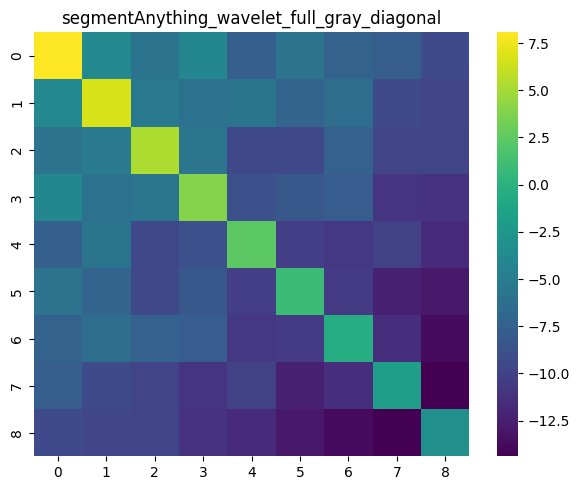

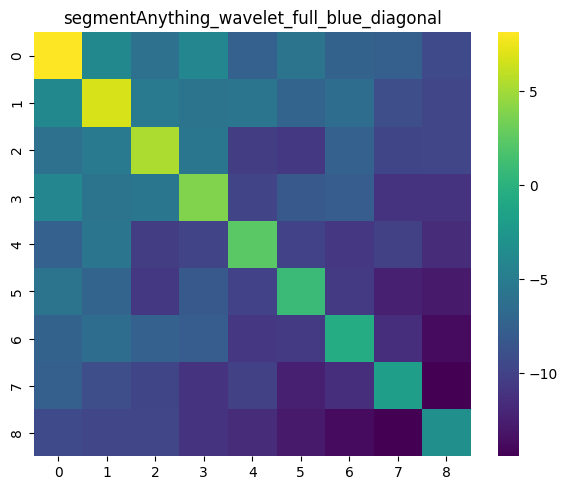

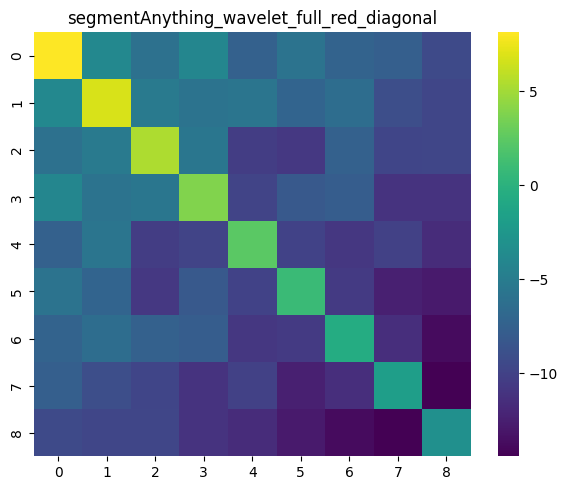

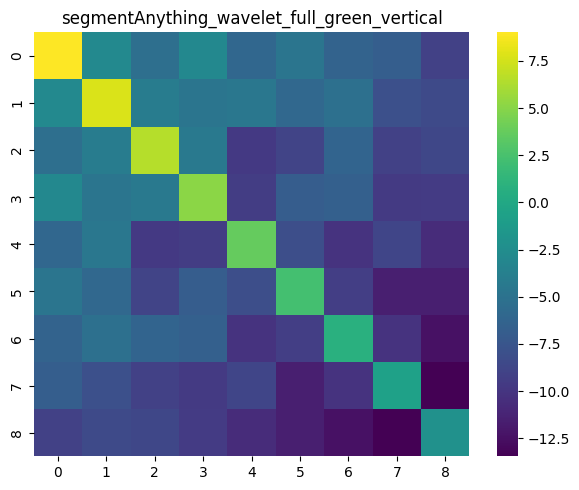

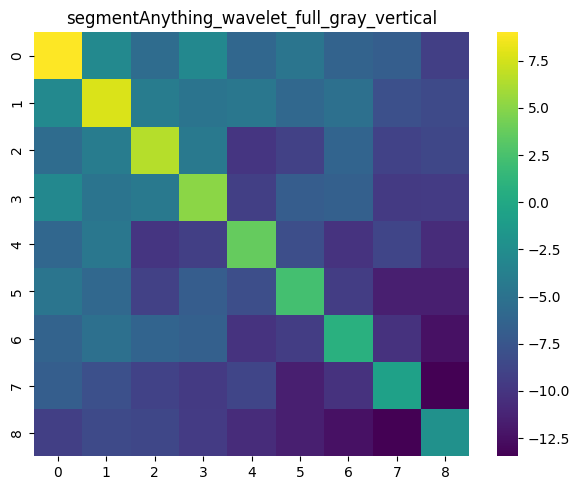

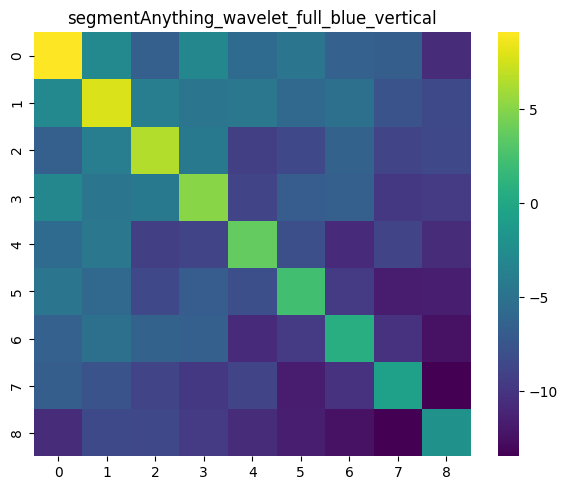

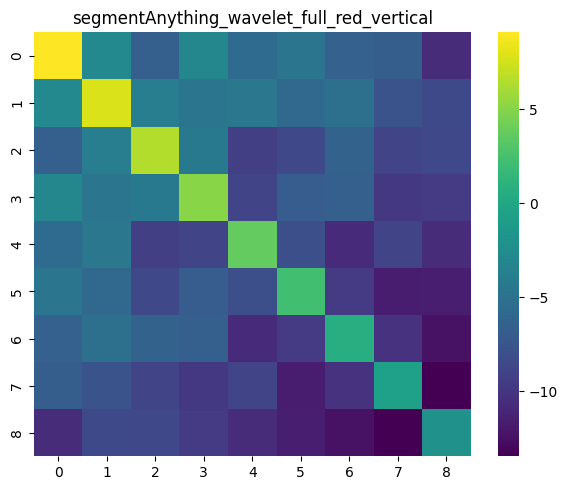

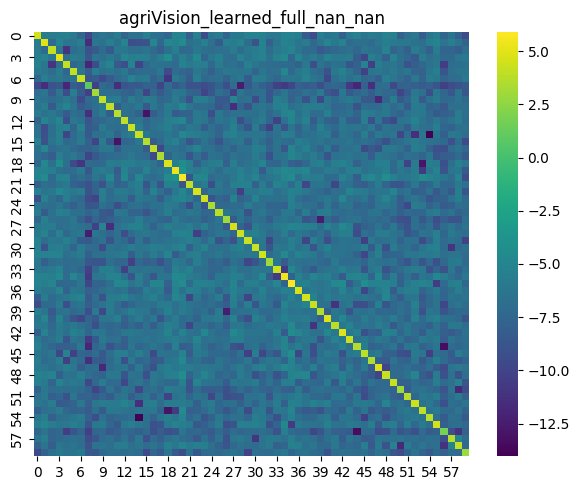

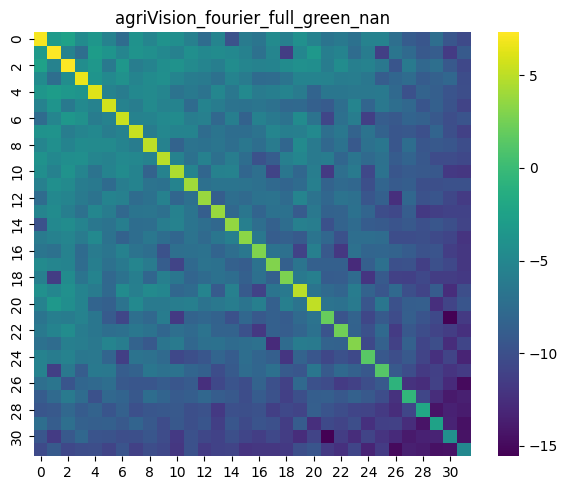

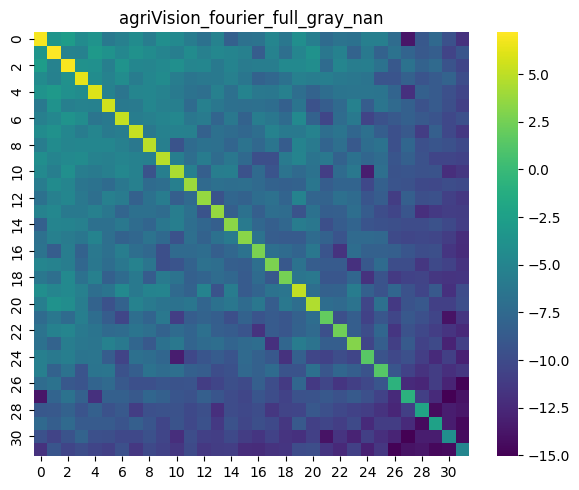

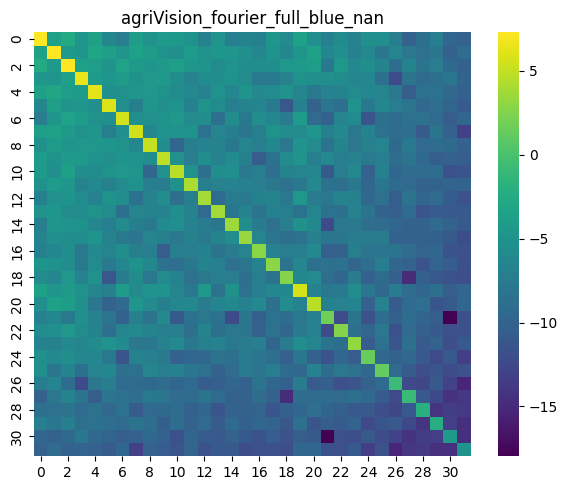

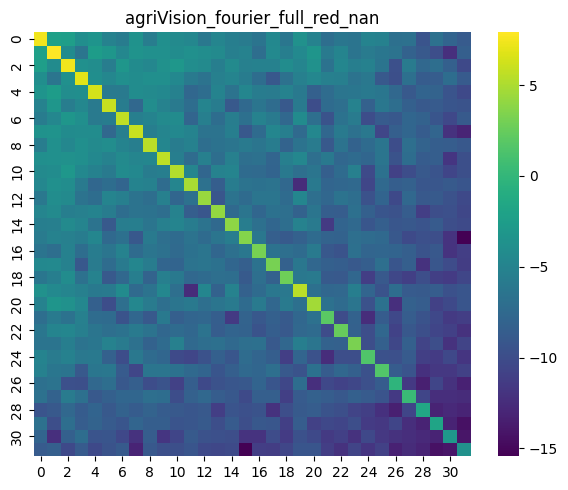

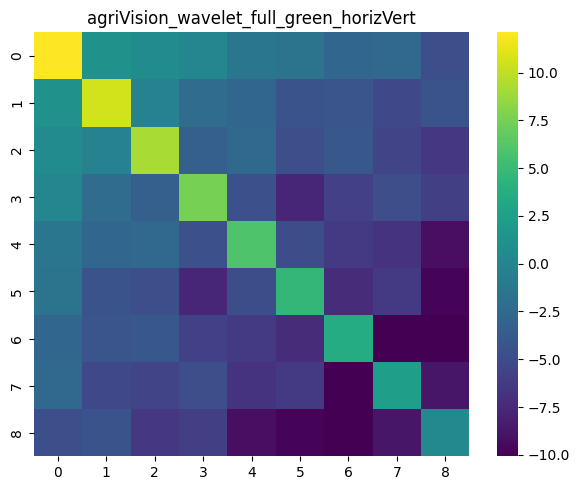

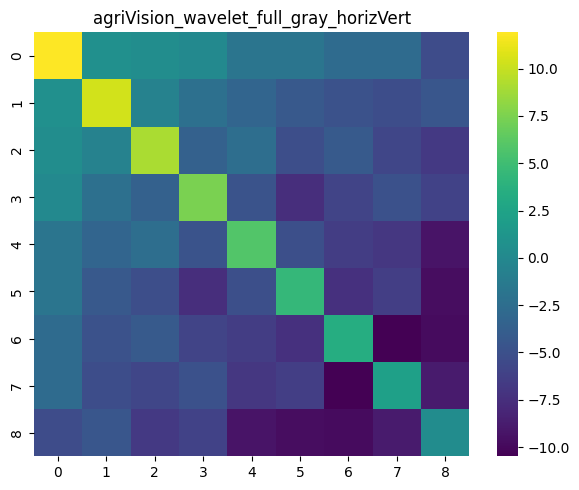

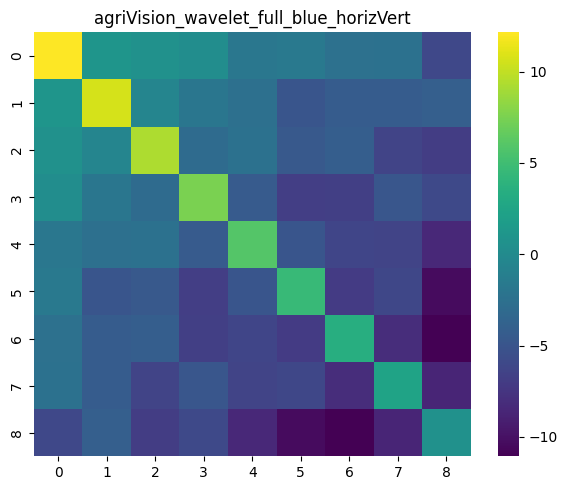

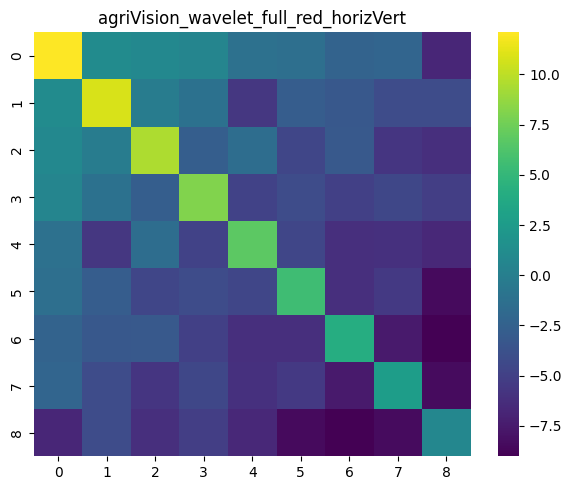

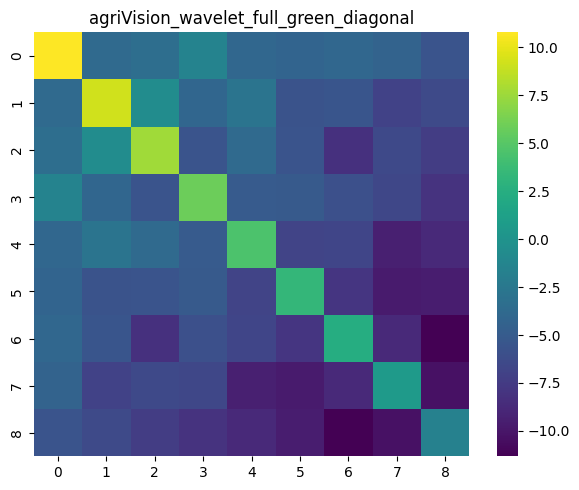

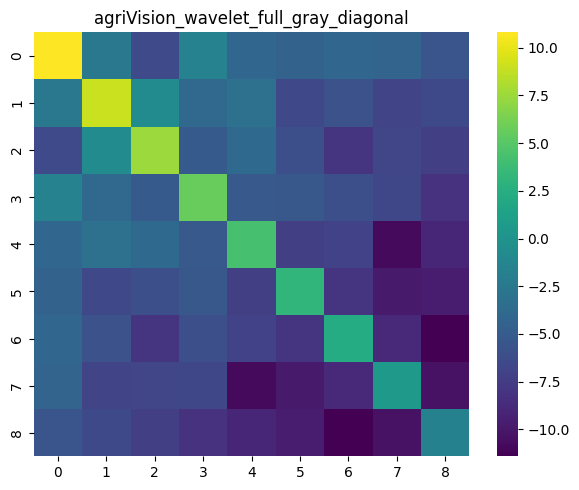

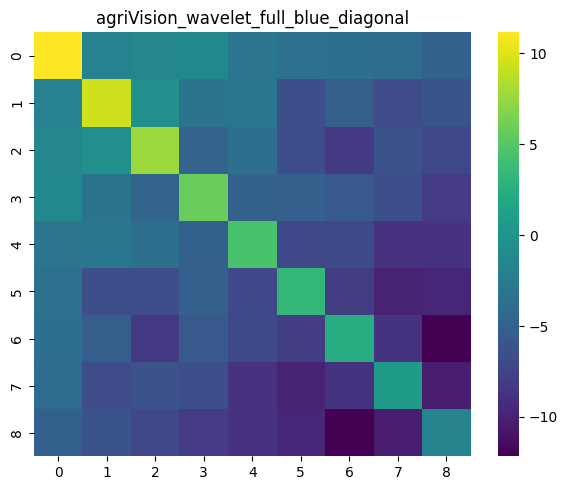

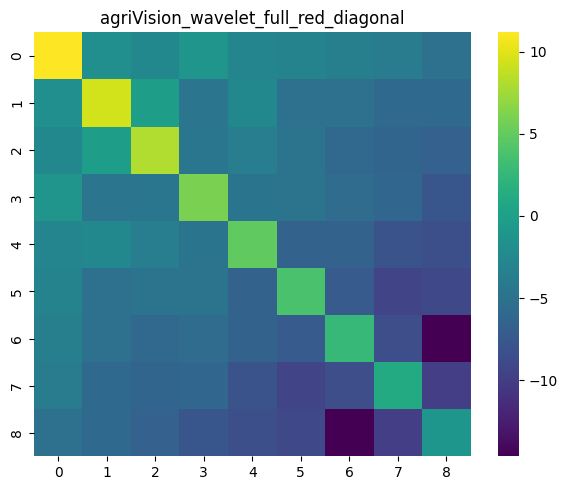

In [13]:
for idx, row in cov_main_df.iterrows():
    cov_matrix = np.array(row['cov_matrix'])
    plt.figure(figsize=(6, 5))
    sns.heatmap(np.log(np.abs(cov_matrix) + 1e-12), cmap='viridis')
    plt.title(f"{row['dataset']}_{row['transform']}_{row['subset']}_{row['channel']}_{row['orientation']}")
    plt.tight_layout()
    #filename = f"{row['dataset']}_{row['transform']}_{row['subset']}_{row['channel']}_{row['orientation']}_cov_heatmap.png"
    #filename = filename.replace(' ', '_').replace('/', '_')
    #plt.savefig(filename)
    plt.show()
    plt.close()